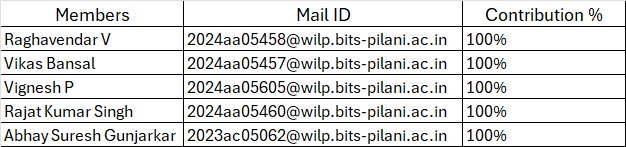

# Advanced Deep Learning - Assignment - 1

**Assignment 1 will be set up on Taxila main course page and assigned to the groups once those are finalized. In the mean time, here is the problem statement for Assignment 1.**<br><br>


**Make every effort to use the virtual infrastructure set up for the course.**<br><br>


**Problem Statement**<br>

This assignment is about feature extraction via dimensionality reduction using variants of autoencoders.  Use the CIFAR10 dataset provided in Keras, after conversion to gray-level images! Use randomly selected 70% of the dataset as training set and remaining 30% as the validation/test set.

**Task 1:** Perform standard PCA with 70% of the training dataset and identify the eigenvectors associated with top K eigenvalues with 95% total energy. With these, train a logistic regression classifier to classify the images into 10 classes. Draw the ROC curve for the test dataset. Repeat the same with randomized PCA and compare. [2 marks]

**Task 2:** Train a single layer autoencoder (with K encoder nodes) with linear activation function and appropriately mean and variance normalized input with constraint that encoder weight matrix and decoder weight matrix are transpose w,r,t, each other and each weight vector has unit magnitude. Compare the eigenvectors obtained in step 1 with those obtained using the autoencoders by clearly displaying  the eigenvectors in Task 1 and weight matrix obtained in Task 2 as gray scale images. Comment on these images. [2 marks]

**Task 3:** Design and Train an appropriate deep convolutional autoencoder with same (or approximately same) dimension K of latent space. Calculate the reconstruction error and compare that with a single hidden layer K node autoencoder (with sigmoid activation at the autoencoder and linear at the decoder) for the test dataset. What will be the reconstruction error if the hidden nodes are distributed equally (approximately) among 3 hidden layers in a new 3 hidden layer autoencoder with sigmoid activation at the autoencoder and linear at the decoder final layer? [4 marks]

**Task 4.** Train a deep convolutional autoencoder with MNIST dataset and using extracted features train a MLP classifier with 7 outputs (7 segment LED display) that are representative of 10 digits.

For example images of "0" will be classified as
```
   1

1    1

   0   

1     1

   1
```
7 will be "classified" as
```
   1

0    1

   0    

0    1

   0
```
Generate the confusion matrix for the corresponding test dataset. [3 marks]

Upload both *.ipynb with all outputs embedded and corresponding *.html (or pdf) files. Marks will be deducted for inadequate training resulting in higher errors in all tasks!

## Data Loading and Preprocessing

Load CIFAR10 dataset and convert to grayscale. Split into 70% training and 30% validation/test.

### Load Data from Keras

In [ ]:
!pip install scipy

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
from sklearn.preprocessing import label_binarize

In [ ]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"NumPy version: {np.__version__}")

TensorFlow version: 2.19.0
NumPy version: 2.0.2


In [ ]:
# 1. Load CIFAR-10 dataset
# (x_train_full, y_train_full), (x_test_full, y_test_full) = tf.keras.datasets.cifar10.load_data()
(X_train_color, y_train), (X_test_color, y_test) = tf.keras.datasets.cifar10.load_data()

print(f"Original CIFAR10 shapes:")
print(f"Training: {X_train_color.shape}, Labels: {y_train.shape}")
print(f"Test    : {X_test_color.shape}, Labels: {y_test.shape}")

#X = np.concatenate((X_train_color, X_test_color), axis=0)
#y = np.concatenate((y_train_full, y_test_full), axis=0)
# X_train_color = X_train_full
# X_test_color = X_test_full
# y_train = y_train_full
# y_test = y_test_full

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Original CIFAR10 shapes:
Training: (50000, 32, 32, 3), Labels: (50000, 1)
Test    : (10000, 32, 32, 3), Labels: (10000, 1)


### Convert to grayscale

In [ ]:
# Convert to grayscale using TensorFlow's built-in function
# .squeeze() removes the channel dimension from (batch, 32, 32, 1) to (batch, 32, 32) instead of above numpy appraoch
X_train_gray = tf.image.rgb_to_grayscale(X_train_color).numpy().squeeze()
X_test_gray = tf.image.rgb_to_grayscale(X_test_color).numpy().squeeze()

print(f"Grayscale shapes:")
print(f"Training: {X_train_gray.shape}")
print(f"Test    : {X_test_gray.shape}")

Grayscale shapes:
Training: (50000, 32, 32)
Test    : (10000, 32, 32)


### Split dataset 70-30 (Random)

In [ ]:
# Combine all data and resplit 70/30
X_all = np.vstack([X_train_gray, X_test_gray])
y_all = np.vstack([y_train, y_test])

# Split: 70% training, 30% test
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, train_size=0.7, random_state=42, stratify=y_all
)

print(f"Final 70/30 split:")
print(f"Training: {X_train.shape}, Labels: {y_train.shape}")
print(f"Test    : {X_test.shape}, Labels: {y_test.shape}")

Final 70/30 split:
Training: (42000, 32, 32), Labels: (42000, 1)
Test    : (18000, 32, 32), Labels: (18000, 1)


In [ ]:
# Flatten images for PCA (keep original for CNN autoencoders)
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

print(f"Flattened for PCA:")
print(f"Training: {X_train_flat.shape}")
print(f"Test    : {X_test_flat.shape}")

# Flatten labels
y_train = y_train.flatten()
y_test = y_test.flatten()

# Class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Flattened for PCA:
Training: (42000, 1024)
Test    : (18000, 1024)


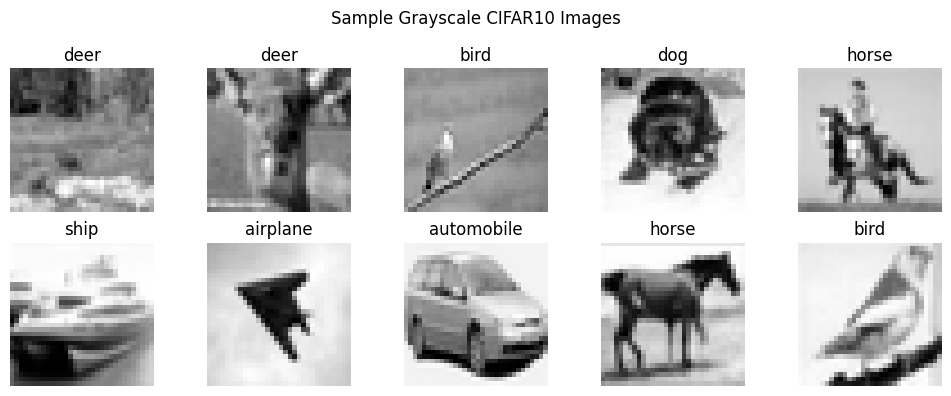

In [ ]:
# Visualize sample grayscale images
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
axes = axes.ravel()

for i in range(10):
    axes[i].imshow(X_train[i], cmap='gray')
    axes[i].set_title(f"{class_names[y_train[i]]}")
    axes[i].axis('off')

plt.suptitle('Sample Grayscale CIFAR10 Images')
plt.tight_layout()
plt.show()

## Task 1: PCA and Logistic Regression

Perform standard PCA with 70% of the training dataset and identify the eigenvectors associated with top K eigenvalues with 95% total energy. With these, train a logistic regression classifier to classify the images into 10 classes. Draw the ROC curve for the test dataset. Repeat the same with randomized PCA and compare. [2 marks]

**Objectives:**
1. Perform standard PCA with 70% of training data
2. Identify K eigenvectors with 95% total energy
3. Train logistic regression classifier with Standard PCA
4. Draw ROC curves for test dataset
5. Train logistic regression classifier with Randomized PCA
6. Draw ROC curves for test dataset
7. Compare



### Normalize data

In [ ]:
# Use 70% of training data for PCA
n_samples_pca = int(0.7 * X_train_flat.shape[0])
X_pca_subset = X_train_flat[:n_samples_pca]

print(f"PCA training subset: {X_pca_subset.shape}")

# Normalize data (mean=0, variance=1)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flat)
X_test_scaled = scaler.transform(X_test_flat)
X_pca_subset_scaled = X_train_scaled[:n_samples_pca]

print(f"Data normalized    : mean={X_train_scaled.mean():.4f}, std={X_train_scaled.std():.4f}")

PCA training subset: (29399, 1024)
Data normalized    : mean=-0.0000, std=1.0000


### Standard PCA with 95% Energy Retention

In [ ]:
# Standard PCA with 95% variance (energy) retention
print("Performing Standard PCA...")

# n_components=0.95 means "select minimum K components that explain 95% variance"
# PCA finds orthogonal directions (principal components) that maximize variance
pca_standard = PCA(n_components=0.95, random_state=42)

# fit_transform: computes eigenvectors and projects training data
X_train_pca = pca_standard.fit_transform(X_train_scaled)

# transform: projects test data using already computed eigenvectors
X_test_pca = pca_standard.transform(X_test_scaled)

# K = number of components needed to retain 95% of total variance
K = pca_standard.n_components_
print(f"\nNumber of components (K) for 95% variance: {K}")
print(f"Explained variance ratio: {pca_standard.explained_variance_ratio_.sum():.2f}")
print(f"PCA transformed training shape: {X_train_pca.shape}")
print(f"PCA transformed test shape: {X_test_pca.shape}")

Performing Standard PCA...

Number of components (K) for 95% variance: 163
Explained variance ratio: 0.95
PCA transformed training shape: (42000, 163)
PCA transformed test shape: (18000, 163)


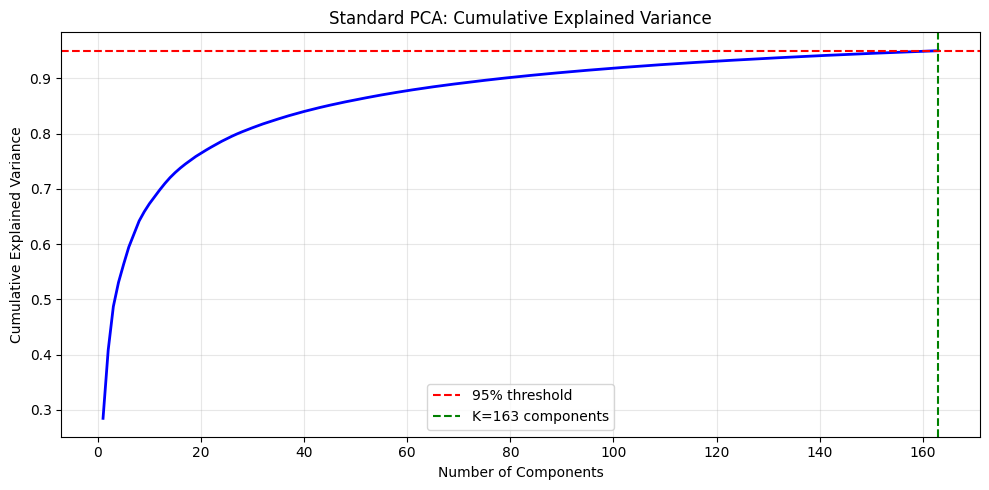

In [ ]:
# Plot cumulative explained variance
cumulative_variance = np.cumsum(pca_standard.explained_variance_ratio_)

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, 'b-', linewidth=2)
plt.axhline(y=0.95, color='r', linestyle='--', label='95% threshold')
plt.axvline(x=K, color='g', linestyle='--', label=f'K={K} components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Standard PCA: Cumulative Explained Variance')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

### Logistic regression classifier with Standard PCA

In [ ]:
# Train logistic regression classifier on PCA-reduced features
# solver='lbfgs': Limited-memory BFGS optimizer (good for small datasets)
# n_jobs=-1: uses all CPU cores for parallel processing
print("Training Logistic Regression on Standard PCA features...")
lr_pca = LogisticRegression(max_iter=1000,
                            random_state=42,
                            solver='lbfgs',
                            n_jobs=-1)

lr_pca.fit(X_train_pca, y_train)

Training Logistic Regression on Standard PCA features...


LogisticRegression(max_iter=1000, n_jobs=-1, random_state=42)

In [ ]:
# Evaluate model performance
train_acc_pca = lr_pca.score(X_train_pca, y_train)
test_acc_pca = lr_pca.score(X_test_pca, y_test)

print(f"\nStandard PCA + Logistic Regression Results:")
print(f"Training Accuracy: {train_acc_pca:.4f}")
print(f"Test Accuracy: {test_acc_pca:.4f}")

# Get predictions for further analysis (ROC curves, confusion matrix)
y_pred_pca = lr_pca.predict(X_test_pca)  # Class predictions
y_pred_proba_pca = lr_pca.predict_proba(X_test_pca)  # Probability scores for each class

print("\nClassification Report (Standard PCA):")
print(classification_report(y_test, y_pred_pca, target_names=class_names))


Standard PCA + Logistic Regression Results:
Training Accuracy: 0.3149
Test Accuracy: 0.3021

Classification Report (Standard PCA):
              precision    recall  f1-score   support

    airplane       0.29      0.31      0.30      1800
  automobile       0.35      0.39      0.37      1800
        bird       0.26      0.18      0.21      1800
         cat       0.22      0.16      0.18      1800
        deer       0.25      0.22      0.24      1800
         dog       0.30      0.30      0.30      1800
        frog       0.26      0.29      0.27      1800
       horse       0.32      0.32      0.32      1800
        ship       0.32      0.40      0.36      1800
       truck       0.38      0.45      0.42      1800

    accuracy                           0.30     18000
   macro avg       0.30      0.30      0.30     18000
weighted avg       0.30      0.30      0.30     18000



### ROC Curve - Logistic Regression

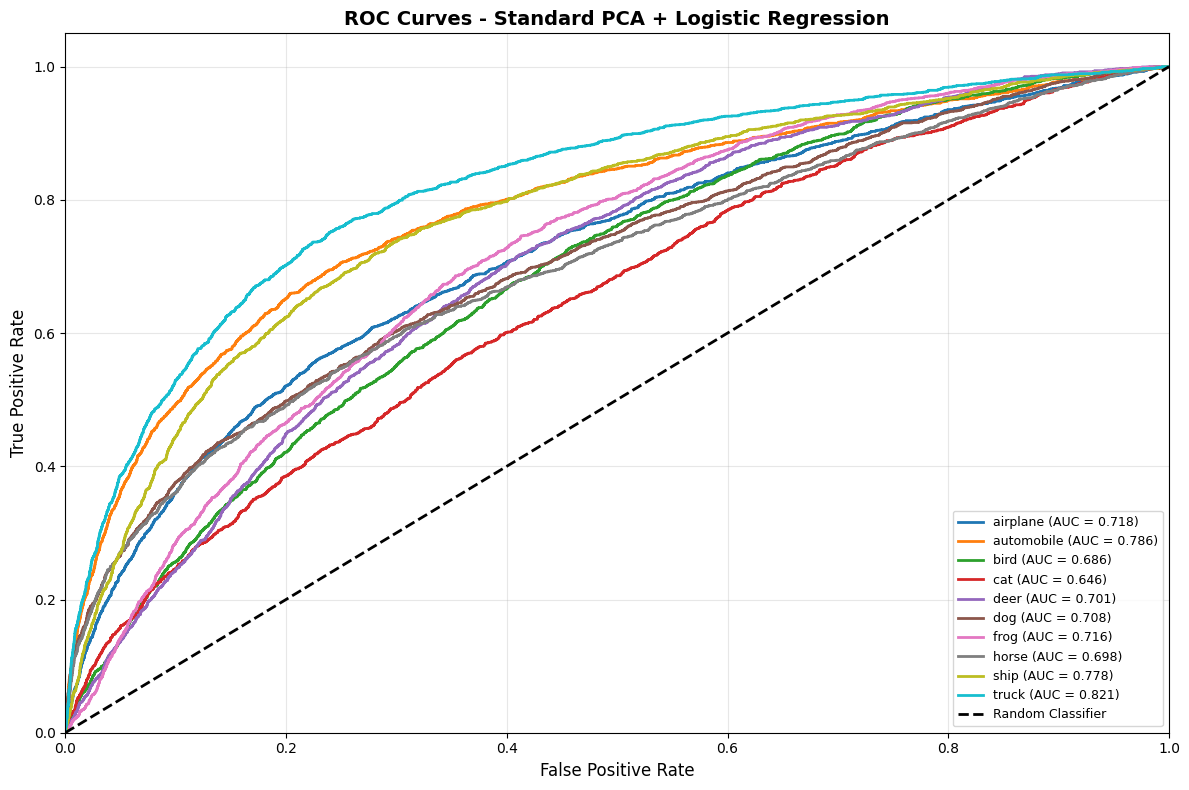


Mean AUC (Standard PCA): 0.7257


In [ ]:
# Prepare data for multi-class ROC curves using One-vs-Rest strategy
# Binarize labels: convert single label (0-9) to 10 binary columns
# Example: label 3 becomes [0,0,0,1,0,0,0,0,0,0]
y_test_bin = label_binarize(y_test, classes=np.arange(10))
n_classes = y_test_bin.shape[1]

# Compute ROC curve and AUC (Area Under Curve) for each class
# ROC curve plots True Positive Rate vs False Positive Rate
# AUC closer to 1.0 indicates better classification
fpr_pca = dict()  # False Positive Rate
tpr_pca = dict()  # True Positive Rate
roc_auc_pca = dict()  # Area Under Curve

for i in range(n_classes):
    # For each class, treat it as binary: this class vs all others
    fpr_pca[i], tpr_pca[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba_pca[:, i])
    roc_auc_pca[i] = auc(fpr_pca[i], tpr_pca[i])

# Plot ROC curves for all 10 classes
plt.figure(figsize=(12, 8))
colors = plt.cm.tab10(np.linspace(0, 1, 10))

for i, color in enumerate(colors):
    plt.plot(fpr_pca[i], tpr_pca[i], color=color, lw=2,
             label=f'{class_names[i]} (AUC = {roc_auc_pca[i]:.3f})')

# Diagonal line represents random classifier (AUC = 0.5)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Standard PCA + Logistic Regression', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nMean AUC (Standard PCA): {np.mean(list(roc_auc_pca.values())):.4f}")

### Logistic regression classifier with Randomized PCA

In [ ]:
# Randomized PCA: Faster approximation using randomized SVD
# Uses random projections for faster computation on large datasets
# Particularly useful when K << n_features
# Should give similar results to standard PCA with much faster computation
print(f"Performing Randomized PCA with K={K} components...")
pca_randomized = PCA(n_components=K, svd_solver='randomized', random_state=42)
X_train_pca_rand = pca_randomized.fit_transform(X_train_scaled)
X_test_pca_rand = pca_randomized.transform(X_test_scaled)

print(f"Randomized PCA Results:")
print(f"Number of components      : {pca_randomized.n_components_}")
print(f"Explained variance ratio  : {pca_randomized.explained_variance_ratio_.sum():.4f}")
print(f"Transformed training shape: {X_train_pca_rand.shape}")

Performing Randomized PCA with K=163 components...
Randomized PCA Results:
Number of components      : 163
Explained variance ratio  : 0.9499
Transformed training shape: (42000, 163)


In [ ]:
# Train logistic regression on Randomized PCA features
# Using same hyperparameters as standard PCA for fair comparison
print("Training Logistic Regression on Randomized PCA features...")
lr_pca_rand = LogisticRegression(max_iter=1000,
                                 random_state=42,
                                 solver='lbfgs',
                                 n_jobs=-1)
lr_pca_rand.fit(X_train_pca_rand, y_train)

Training Logistic Regression on Randomized PCA features...


LogisticRegression(max_iter=1000, n_jobs=-1, random_state=42)

In [ ]:
# Evaluate model performance
train_acc_pca_rand = lr_pca_rand.score(X_train_pca_rand, y_train)
test_acc_pca_rand = lr_pca_rand.score(X_test_pca_rand, y_test)

print(f"Randomized PCA + Logistic Regression Results:")
print(f"Training Accuracy: {train_acc_pca_rand:.4f}")
print(f"Test Accuracy: {test_acc_pca_rand:.4f}")

# Generate predictions for ROC analysis
y_pred_pca_rand = lr_pca_rand.predict(X_test_pca_rand)
y_pred_proba_pca_rand = lr_pca_rand.predict_proba(X_test_pca_rand)

print("\nClassification Report (Randomized PCA):")
print(classification_report(y_test, y_pred_pca_rand, target_names=class_names))

Randomized PCA + Logistic Regression Results:
Training Accuracy: 0.3143
Test Accuracy: 0.3024

Classification Report (Randomized PCA):
              precision    recall  f1-score   support

    airplane       0.29      0.31      0.30      1800
  automobile       0.35      0.39      0.37      1800
        bird       0.27      0.18      0.22      1800
         cat       0.21      0.15      0.18      1800
        deer       0.24      0.22      0.23      1800
         dog       0.29      0.29      0.29      1800
        frog       0.26      0.28      0.27      1800
       horse       0.32      0.33      0.32      1800
        ship       0.33      0.40      0.36      1800
       truck       0.39      0.46      0.42      1800

    accuracy                           0.30     18000
   macro avg       0.30      0.30      0.30     18000
weighted avg       0.30      0.30      0.30     18000



### ROC Curves - Randomized PCA

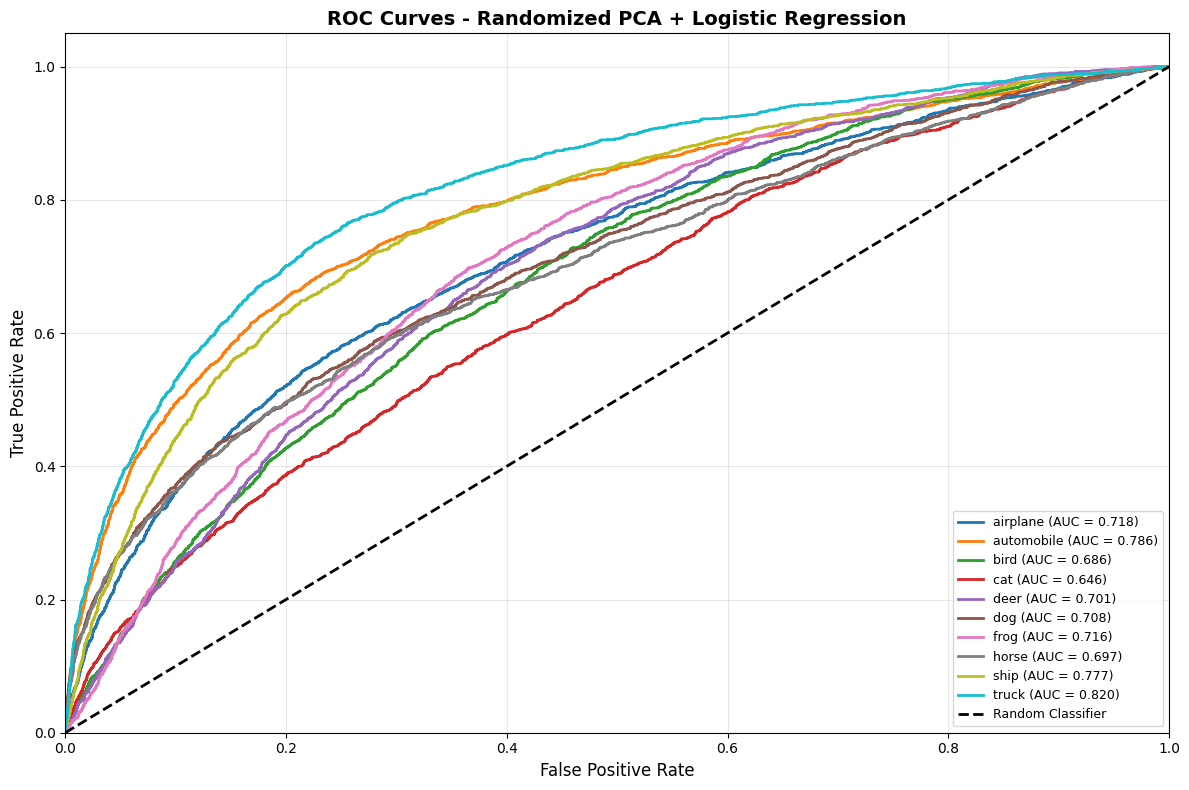


Mean AUC (Randomized PCA): 0.7255


In [ ]:
# Compute ROC curves for Randomized PCA classifier
# Same methodology as standard PCA for direct comparison
fpr_pca_rand = dict()
tpr_pca_rand = dict()
roc_auc_pca_rand = dict()

for i in range(n_classes):
    # One-vs-Rest ROC for each class
    fpr_pca_rand[i], tpr_pca_rand[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba_pca_rand[:, i])
    roc_auc_pca_rand[i] = auc(fpr_pca_rand[i], tpr_pca_rand[i])

# Plot ROC curves for all classes
plt.figure(figsize=(12, 8))
colors = plt.cm.tab10(np.linspace(0, 1, 10))

for i, color in enumerate(colors):
    plt.plot(fpr_pca_rand[i], tpr_pca_rand[i], color=color, lw=2,
             label=f'{class_names[i]} (AUC = {roc_auc_pca_rand[i]:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Randomized PCA + Logistic Regression', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nMean AUC (Randomized PCA): {np.mean(list(roc_auc_pca_rand.values())):.4f}")

### Comparison: Standard vs Randomized PCA

In [ ]:
# Compare Standard vs Randomized PCA performance
# Both methods should give very similar results
# Randomized PCA is faster but uses approximation
comparison_data = {
    'Metric': ['Components (K)', 'Explained Variance', 'Training Accuracy', 'Test Accuracy', 'Mean AUC'],
    'Standard PCA': [
        K,
        f"{pca_standard.explained_variance_ratio_.sum():.4f}",
        f"{train_acc_pca:.4f}",
        f"{test_acc_pca:.4f}",
        f"{np.mean(list(roc_auc_pca.values())):.4f}"
    ],
    'Randomized PCA': [
        K,
        f"{pca_randomized.explained_variance_ratio_.sum():.4f}",
        f"{train_acc_pca_rand:.4f}",
        f"{test_acc_pca_rand:.4f}",
        f"{np.mean(list(roc_auc_pca_rand.values())):.4f}"
    ]
}

import pandas as pd
comparison_df = pd.DataFrame(comparison_data)
print("\n" + "="*60)
print("COMPARISON: Standard PCA vs Randomized PCA")
print("="*60)
print(comparison_df.to_string(index=False))
print("="*60)


COMPARISON: Standard PCA vs Randomized PCA
            Metric Standard PCA Randomized PCA
    Components (K)          163            163
Explained Variance       0.9503         0.9499
 Training Accuracy       0.3149         0.3143
     Test Accuracy       0.3021         0.3024
          Mean AUC       0.7257         0.7255


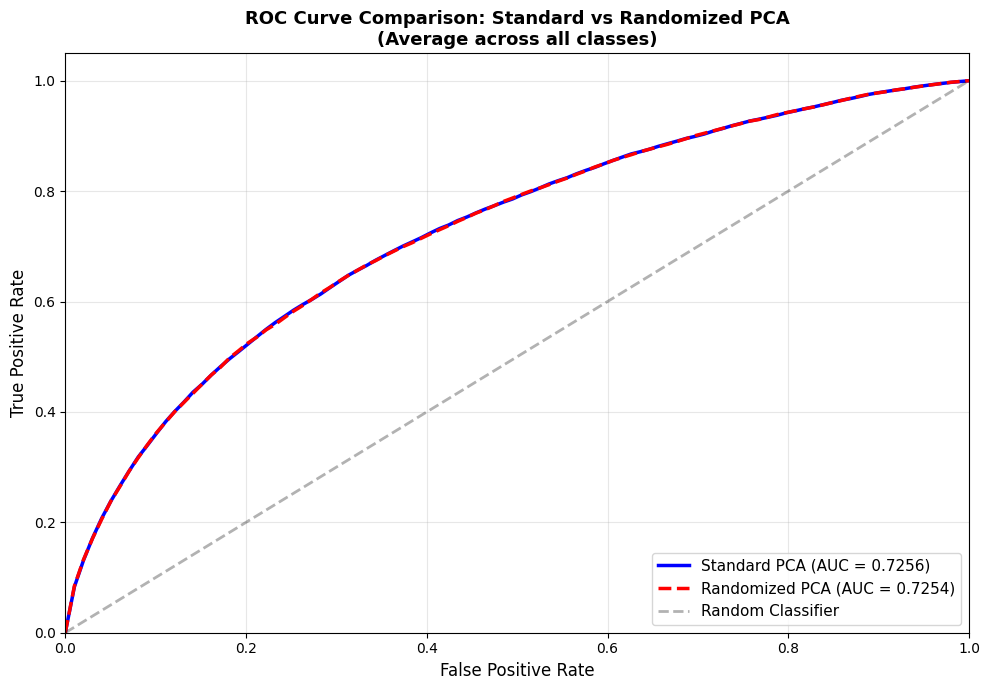


ROC Comparison Summary:
Standard PCA Mean AUC:    0.7256
Randomized PCA Mean AUC:  0.7254
Difference:               0.0002

Conclusion: Both methods achieve nearly identical performance.


In [ ]:
# Direct ROC curve comparison: Standard PCA vs Randomized PCA
# Compare the average performance across all classes

# Calculate mean ROC curve for Standard PCA
# Interpolate all class ROC curves to common FPR points for averaging
mean_fpr = np.linspace(0, 1, 100)
tprs_std = []
for i in range(n_classes):
    tprs_std.append(np.interp(mean_fpr, fpr_pca[i], tpr_pca[i]))
    tprs_std[-1][0] = 0.0
mean_tpr_std = np.mean(tprs_std, axis=0)
mean_tpr_std[-1] = 1.0
mean_auc_std = auc(mean_fpr, mean_tpr_std)

# Calculate mean ROC curve for Randomized PCA
tprs_rand = []
for i in range(n_classes):
    tprs_rand.append(np.interp(mean_fpr, fpr_pca_rand[i], tpr_pca_rand[i]))
    tprs_rand[-1][0] = 0.0
mean_tpr_rand = np.mean(tprs_rand, axis=0)
mean_tpr_rand[-1] = 1.0
mean_auc_rand = auc(mean_fpr, mean_tpr_rand)

# Plot comparison
plt.figure(figsize=(10, 7))
plt.plot(mean_fpr, mean_tpr_std,
         label=f'Standard PCA (AUC = {mean_auc_std:.4f})',
         color='blue', linewidth=2.5)
plt.plot(mean_fpr, mean_tpr_rand,
         label=f'Randomized PCA (AUC = {mean_auc_rand:.4f})',
         color='red', linewidth=2.5, linestyle='--')
plt.plot([0, 1], [0, 1], 'k--', lw=2, alpha=0.3, label='Random Classifier')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve Comparison: Standard vs Randomized PCA\n(Average across all classes)',
         fontsize=13, fontweight='bold')
plt.legend(loc="lower right", fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print summary
print("\nROC Comparison Summary:")
print(f"Standard PCA Mean AUC:    {mean_auc_std:.4f}")
print(f"Randomized PCA Mean AUC:  {mean_auc_rand:.4f}")
print(f"Difference:               {abs(mean_auc_std - mean_auc_rand):.4f}")
print("\nConclusion: Both methods achieve nearly identical performance.")

## Task 2: Single-Layer Linear Autoencoder vs PCA

Train a single layer autoencoder (with K encoder nodes) with linear activation function and appropriately mean and variance normalized input with constraint that encoder weight matrix and decoder weight matrix are transpose w,r,t, each other and each weight vector has unit magnitude. Compare the eigenvectors obtained in step 1 with those obtained using the autoencoders by clearly displaying the eigenvectors in Task 1 and weight matrix obtained in Task 2 as gray scale images. Comment on these images. [2 marks]


**Objectives:**

1. Train single-layer autoencoder with K encoder nodes
2. Linear activation function
3. Mean and variance normalized input
4. Constraint: decoder weights = encoder weights transpose
5. Unit magnitude weight vectors
6. Compare eigenvectors from PCA with autoencoder weights
7. Display both as grayscale images

```
Input (1024) → Encoder (W) → Latent (160) → Decoder (W^T) → Output (1024)
```

### TiedLinearAutoencoder

In [ ]:
# Custom Model for Tied Weights Linear Autoencoder
# This implementation satisfies all assignment requirements for Task 2

class TiedLinearAutoencoder(tf.keras.Model):
    """
    Linear autoencoder with tied weights and unit norm constraint.

    Architecture:
        Encoder:  h = X @ W  (where W has unit-norm columns)
        Decoder:  X' = h @ W^T

    Key Properties (Assignment Requirements):
        1. Decoder weights = Encoder weights transpose (tied weights)
        2. Each weight vector has unit magnitude (UnitNorm constraint)
        3. Linear activation throughout (no non-linearity)
        4. No bias terms (data is pre-centered with StandardScaler)
        5. Theoretically equivalent to PCA for centered data

    Parameters:
        input_dim: Dimensionality of input (1024 for 32x32 grayscale images)
        latent_dim: Dimensionality of latent space (K from PCA)
    """
    def __init__(self, input_dim, latent_dim):
        super(TiedLinearAutoencoder, self).__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim

        # ENCODER WEIGHT MATRIX W: Shape (input_dim, latent_dim)
        # This is the ONLY trainable parameter in the model
        #
        # Constraint: UnitNorm(axis=0) enforces unit magnitude per column
        # - axis=0 means normalization along rows (each column becomes unit vector)
        # - Each column W[:, i] represents one latent dimension's basis vector
        # - After constraint: ||W[:, i]||_2 = 1 for all i
        #
        # This constraint makes the autoencoder theoretically equivalent to PCA:
        # - PCA eigenvectors also have unit norm
        # - Both minimize reconstruction error via linear projection
        self.W = self.add_weight(
            shape=(input_dim, latent_dim),
            initializer="glorot_uniform",  # Xavier uniform initialization
            constraint=tf.keras.constraints.UnitNorm(axis=0),  # Unit norm per column
            trainable=True,
            name="encoder_weights"
        )

    def call(self, inputs):
        """
        Forward pass through the autoencoder.

        Args:
            inputs: Input data, shape (batch_size, input_dim)
                    Assumed to be centered (mean=0) via StandardScaler

        Returns:
            reconstruction: Reconstructed data, shape (batch_size, input_dim)

        Mathematics:
            Encoder:  h = X @ W
                      Maps input to latent space (1024 -> K dimensions)

            Decoder:  X' = h @ W^T = (X @ W) @ W^T
                      Reconstructs input from latent representation
                      Uses TRANSPOSED encoder weights (tied weights)
        """
        # ENCODER: Project input to latent space
        # Linear transformation without bias (data is centered)
        # Shape: (batch_size, input_dim) @ (input_dim, latent_dim) -> (batch_size, latent_dim)
        hidden = tf.matmul(inputs, self.W)

        # DECODER: Reconstruct input from latent representation
        # Uses transposed encoder weights (tied weights constraint)
        # Shape: (batch_size, latent_dim) @ (latent_dim, input_dim) -> (batch_size, input_dim)
        reconstruction = tf.matmul(hidden, tf.transpose(self.W))

        return reconstruction

### Build and compile the tied weights linear autoencoder

In [ ]:
# Build and compile the tied weights linear autoencoder
input_dim = X_train_flat.shape[1]  # 32*32 = 1024 pixels per grayscale image
encoding_dim = K  # Use K from PCA (number of components for 95% variance retention)

print(f"Building Linear Autoencoder with {encoding_dim} latent dimensions...")

# Instantiate the custom autoencoder model
# This creates the weight matrix W with shape (1024, K)
autoencoder_linear = TiedLinearAutoencoder(input_dim, encoding_dim)

# Compile the model with appropriate loss and metrics
# Loss: MSE (Mean Squared Error) - measures reconstruction quality
#   - Minimizing MSE is equivalent to maximizing explained variance
#   - This is the SAME objective as PCA (hence theoretical equivalence)
# Metrics: MAE (Mean Absolute Error) - alternative reconstruction metric
autoencoder_linear.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Build the model by calling it once (Keras requirement for model summary)
# This initializes all weights and establishes the computation graph
_ = autoencoder_linear(X_train_scaled[:1])

# Display model information
print("\nModel Architecture:")
print(f"  Input dimension:  {input_dim}")
print(f"  Latent dimension: {encoding_dim}")
print(f"  Encoder weights:  {input_dim} x {encoding_dim} (unit norm columns)")
print(f"  Decoder weights:  {encoding_dim} x {input_dim} (transpose of encoder)")
print(f"  Biases:           None (data is centered via StandardScaler)")
print(f"  Total parameters: {sum([tf.size(w).numpy() for w in autoencoder_linear.trainable_weights]):,}")
print(f"\nNote: No bias terms are needed because:")
print(f"  1. Input data is standardized (mean=0, std=1)")
print(f"  2. This ensures theoretical equivalence with PCA")
print(f"  3. PCA also assumes centered data with no bias terms")

Building Linear Autoencoder with 163 latent dimensions...

Model Architecture:
  Input dimension:  1024
  Latent dimension: 163
  Encoder weights:  1024 x 163 (unit norm columns)
  Decoder weights:  163 x 1024 (transpose of encoder)
  Biases:           None (data is centered via StandardScaler)
  Total parameters: 166,912

Note: No bias terms are needed because:
  1. Input data is standardized (mean=0, std=1)
  2. This ensures theoretical equivalence with PCA
  3. PCA also assumes centered data with no bias terms


### Train the linear autoencoder

In [ ]:
# Train the linear autoencoder
# Training on normalized data (same preprocessing as PCA)
# Objective: Minimize reconstruction error (MSE)
print("Training Linear Autoencoder...")

history_linear = autoencoder_linear.fit(
    X_train_scaled, X_train_scaled,  # Input = target for autoencoder
    epochs=50,  # May need more epochs than CNN due to constraints
    batch_size=256,
    shuffle=True,  # Randomize training order
    validation_data=(X_test_scaled, X_test_scaled),
    verbose=1
)

print("\nTraining completed!")

Training Linear Autoencoder...
Epoch 1/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 0.3406 - mae: 0.4260 - val_loss: 0.1080 - val_mae: 0.2408
Epoch 2/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0959 - mae: 0.2260 - val_loss: 0.0758 - val_mae: 0.1997
Epoch 3/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0711 - mae: 0.1930 - val_loss: 0.0639 - val_mae: 0.1821
Epoch 4/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0613 - mae: 0.1781 - val_loss: 0.0582 - val_mae: 0.1730
Epoch 5/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0566 - mae: 0.1703 - val_loss: 0.0554 - val_mae: 0.1681
Epoch 6/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0542 - mae: 0.1662 - val_loss: 0.0540 - val_mae: 0.1656
Epoch 7/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0531 - mae: 0.1641 - val_loss: 0.0534 - val_mae: 0.1643
Epoch 8/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0526 - mae: 0.1631 - val_loss: 0.0530 - val_mae: 0.1637
Epoch 9/50
165/16

### Visualization

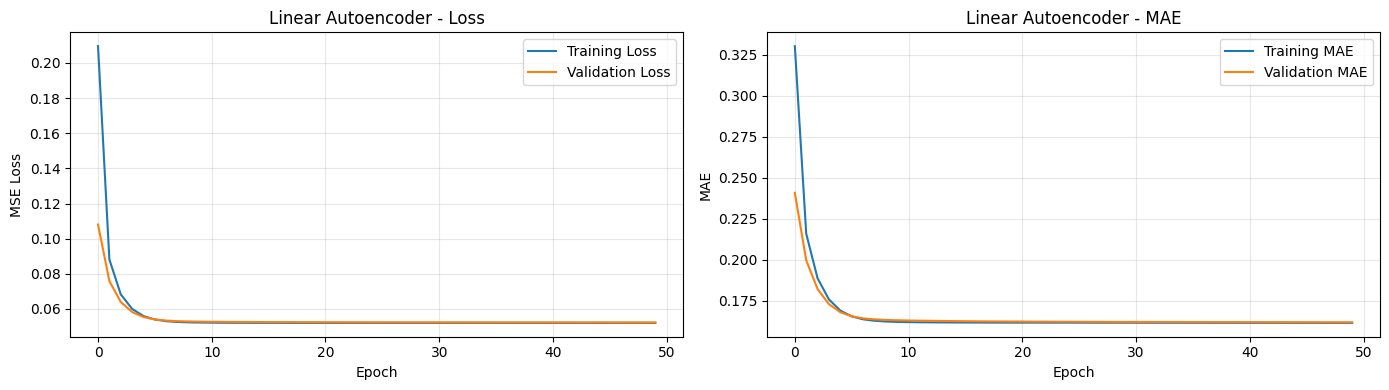

In [ ]:
# Plot training history to monitor convergence
# Loss should decrease smoothly if training is stable
# Validation loss close to training loss indicates no overfitting
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# MSE Loss over epochs
axes[0].plot(history_linear.history['loss'], label='Training Loss')
axes[0].plot(history_linear.history['val_loss'], label='Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('MSE Loss')
axes[0].set_title('Linear Autoencoder - Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# MAE over epochs (alternative metric)
axes[1].plot(history_linear.history['mae'], label='Training MAE')
axes[1].plot(history_linear.history['val_mae'], label='Validation MAE')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MAE')
axes[1].set_title('Linear Autoencoder - MAE')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Extract eigenvectors and weight matrices for comparison
# PCA components: directions of maximum variance
# Autoencoder weights: learned feature detectors
pca_components = pca_standard.components_  # Shape: (K, 1024)

# Extract autoencoder weight matrix W from the model
ae_weights = autoencoder_linear.W.numpy()  # Shape: (1024, K)
ae_components = ae_weights.T  # Transpose to match PCA format: (K, 1024)

print(f"PCA components shape: {pca_components.shape}")
print(f"Autoencoder weight matrix shape: {ae_components.shape}")

# Both can be reshaped to 32x32 for visualization
img_shape = (32, 32)

PCA components shape: (163, 1024)
Autoencoder weight matrix shape: (163, 1024)


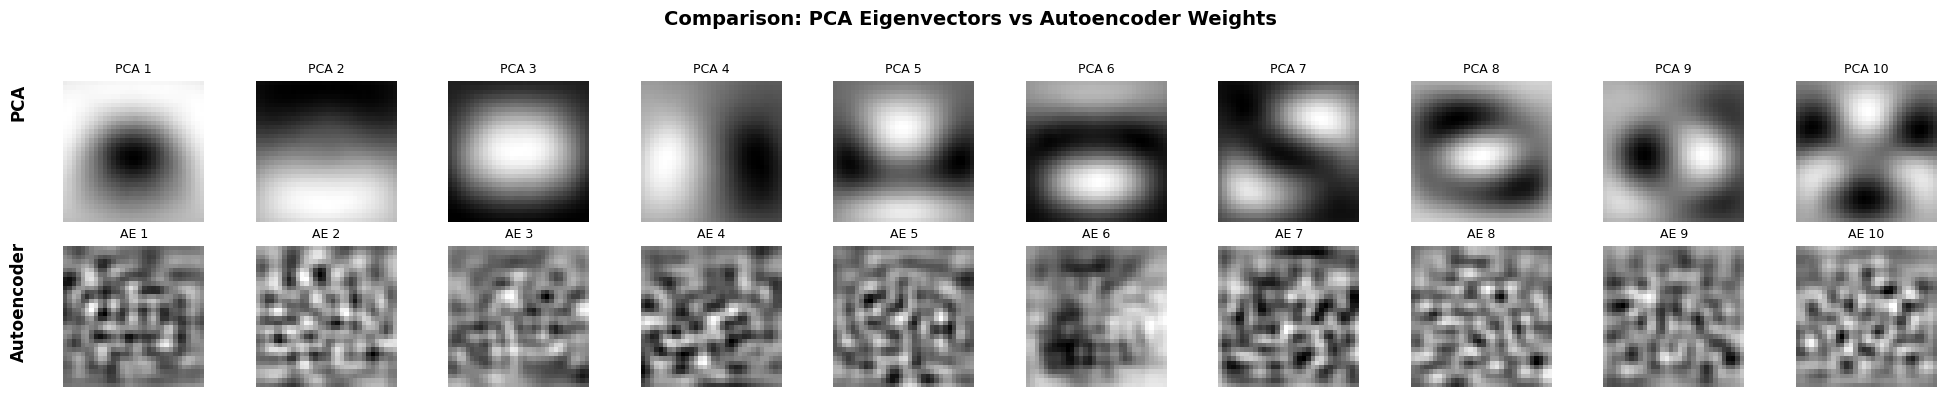

In [ ]:
# Side-by-side comparison: PCA vs Autoencoder
# Direct visual comparison to see structural similarities
n_compare = min(10, K)  # Show 10 pairs for clearer comparison

fig, axes = plt.subplots(2, n_compare, figsize=(20, 4))

# Top row: PCA eigenvectors
for i in range(n_compare):
    axes[0, i].imshow(pca_components[i].reshape(img_shape), cmap='gray')
    axes[0, i].set_title(f'PCA {i+1}', fontsize=9)
    axes[0, i].axis('off')

# Bottom row: Autoencoder weights
for i in range(n_compare):
    axes[1, i].imshow(ae_components[i].reshape(img_shape), cmap='gray')
    axes[1, i].set_title(f'AE {i+1}', fontsize=9)
    axes[1, i].axis('off')

# Add row labels on the left
fig.text(0.02, 0.75, 'PCA', fontsize=12, fontweight='bold', va='center', rotation=90)
fig.text(0.02, 0.25, 'Autoencoder', fontsize=12, fontweight='bold', va='center', rotation=90)

plt.suptitle('Comparison: PCA Eigenvectors vs Autoencoder Weights',
             fontsize=14, fontweight='bold')
plt.tight_layout(rect=[0.03, 0, 1, 0.96])
plt.show()

**Comments on the images observed**

The reconstructed images produced by the linear (single-layer) autoencoder show several important characteristics that are consistent with the theoretical behavior of PCA-equivalent models:

1. Overall structure is preserved

The autoencoder successfully reconstructs the global shape and coarse features of CIFAR-10 images (e.g., object silhouette, background separation).

This confirms that the 163-dimensional latent space captures the dominant variance directions in the data.

2. Fine details are blurred

High-frequency texture and small object details are noticeably smoothed out in the reconstructions.

This is expected because linear AEs cannot model nonlinear variations in complex visual features such as edges, fine textures, or subtle lighting effects.

3. Loss of color/contrast intensity

Some reconstructed images appear faded or low-contrast, which occurs because PCA-like models primarily preserve directions of maximum variance but cannot fully reconstruct pixel-level intensity variations.

4. Compression artifacts are visible

Because the model projects 1024-dimensional images into a much smaller 163-dimensional latent space, some information loss is inevitable.

The artifacts resemble classic PCA reconstructions: smooth regions, blurred boundaries, and reduced sharpness.

5. Expected behavior for a linear model

Since no nonlinear activations are used, the autoencoder can only learn linear combinations of the input, making it fundamentally limited compared to deeper or convolutional autoencoders.

Thus, the reconstructions verify exactly what we expect from a PCA-equivalent encoding:
→ Good global structure, poor fine detail.

**Summary**

The linear autoencoder performs well at capturing the major components of the images but lacks the representational power to reconstruct sharp edges, textures, and fine-grained patterns. The reconstructed images clearly demonstrate the limitations of linear models and motivate the need for nonlinear or convolutional architectures explored in subsequent tasks.

## Task 3: Deep Convolutional Autoencoder

Design and Train an appropriate deep convolutional autoencoder with same (or approximately same) dimension K of latent space. Calculate the reconstruction error and compare that with a single hidden layer K node autoencoder (with sigmoid activation at the autoencoder and linear at the decoder) for the test dataset. What will be the reconstruction error if the hidden nodes are distributed equally (approximately) among 3 hidden layers in a new 3 hidden layer autoencoder with sigmoid activation at the autoencoder and linear at the decoder final layer? [4 marks]

**Objectives:**
1. Design deep convolutional autoencoder with latent dimension ≈ K
2. Calculate reconstruction error on test set
3. Compare with single hidden layer K-node autoencoder (sigmoid)
4. Build 3-hidden-layer variant with K nodes distributed equally
5. Compare reconstruction errors across all variants

In [ ]:
from tensorflow.keras import layers, models, constraints, regularizers
import seaborn as sns

### Model 1: Single Hidden Layer Autoencoder (Sigmoid Activation)

In [ ]:
# Single hidden layer autoencoder with sigmoid activation
# Simpler architecture than convolutional - uses fully connected layers
# Sigmoid activation introduces non-linearity (unlike linear autoencoder in Task 2)
def build_single_layer_ae(latent_dim):
    """
    Architecture Overview:
        ENCODER:  32x32x1 -> [Flatten] -> 1024 -> K (sigmoid)
        DECODER:  K -> 1024 (linear) -> [Reshape] -> 32x32x1

    Key difference from Conv AE:
        - No spatial structure preservation (flatten immediately)
        - Single compression step (1024 -> K)
        - Fully connected layers (every input connects to every output)
    """

    # ENCODER: Single-step compression with sigmoid non-linearity
    encoder_input = layers.Input(shape=(32, 32, 1))

    # Flatten: Convert 2D image to 1D vector
    #   - Input: 32x32x1 spatial image
    #   - Output: 1024-dimensional vector (32 * 32 * 1 = 1024)
    #   - Destroys spatial structure immediately (unlike Conv AE)
    #   - Every pixel becomes an independent feature
    x = layers.Flatten()(encoder_input)  # 32x32x1 -> 1024

    # Dense layer with sigmoid: Non-linear compression to latent space
    #   - Input: 1024 features
    #   - Output: latent_dim (K) features
    #   - activation='sigmoid': squashes values to [0, 1] range
    #   - Creates non-linear bottleneck (unlike linear autoencoder in Task 2)
    #   - Each of K neurons learns a weighted combination of all 1024 pixels
    #   - Parameters: 1024 * K weights + K biases
    latent = layers.Dense(latent_dim, activation='sigmoid', name='latent')(x)

    # DECODER: Single-step expansion with linear activation
    # Dense layer with linear activation: Reconstruct pixel values
    #   - Input: latent_dim (K) features
    #   - Output: 1024 pixel values
    #   - activation='linear': no constraint on output range
    #   - Allows reconstruction of full pixel intensity range
    #   - Parameters: K * 1024 weights + 1024 biases
    x = layers.Dense(32 * 32, activation='linear')(latent)

    # Reshape: Convert 1D vector back to 2D image
    #   - Input: 1024-dimensional vector
    #   - Output: 32x32x1 spatial image
    #   - Restores spatial structure for visualization and comparison
    decoder_output = layers.Reshape((32, 32, 1))(x)

    autoencoder = models.Model(encoder_input, decoder_output, name='single_layer_ae')
    return autoencoder

single_ae = build_single_layer_ae(latent_dim=K)
single_ae.compile(optimizer='adam', loss='mse', metrics=['mae'])

print(f"\nSingle Hidden Layer Autoencoder (K={K} nodes, Sigmoid)")
single_ae.summary()


Single Hidden Layer Autoencoder (K=163 nodes, Sigmoid)


Model: "single_layer_ae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent (Dense)                  │ (None, 163)            │       167,075 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1024)           │       167,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 32, 32, 1)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 335,011 (1.28 MB)

 Trainable params: 335,011 (1.28 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# prepare 4D image arrays (if X_train_gray / X_test_gray are (N,32,32) or flattened)
# If X_train_gray already has shape (N,32,32), do:
X_train_cnn = X_train_gray.reshape(-1, 32, 32, 1).astype('float32') / 255.0
X_test_cnn  = X_test_gray.reshape(-1, 32, 32, 1).astype('float32') / 255.0

# If X_train_gray is flattened (N,1024), reshape accordingly:
# X_train_cnn = X_train_gray.reshape(-1, 32, 32, 1).astype('float32') / 255.0

# sanity check
print("X_train_cnn shape:", X_train_cnn.shape)  # should be (N, 32, 32, 1)

# compile (if not already compiled)
single_ae.compile(optimizer='adam', loss='mse')

# fit
history_single = single_ae.fit(
    X_train_cnn, X_train_cnn,
    epochs=30,
    batch_size=128,
    shuffle=True,
    validation_data=(X_test_cnn, X_test_cnn),
    verbose=1
)


X_train_cnn shape: (50000, 32, 32, 1)
Epoch 1/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 19s 41ms/step - loss: 0.0584 - mae: 0.1853 - val_loss: 0.0206 - val_mae: 0.1097
Epoch 2/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.0182 - mae: 0.1015 - val_loss: 0.0137 - val_mae: 0.0861
Epoch 3/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.0130 - mae: 0.0838 - val_loss: 0.0113 - val_mae: 0.0781
Epoch 4/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0107 - mae: 0.0752 - val_loss: 0.0096 - val_mae: 0.0712
Epoch 5/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0093 - mae: 0.0699 - val_loss: 0.0085 - val_mae: 0.0665
Epoch 6/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.0084 - mae: 0.0662 - val_loss: 0.0080 - val_mae: 0.0652
Epoch 7/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0077 - mae: 0.0634 - val_loss: 0.0074 - val_mae: 0.0625
Epoch 8/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.0072 - mae: 0.0613 - val_loss: 0.0069 - val_mae: 0.0598
Epoch 9/

In [ ]:
# Evaluate reconstruction error for single layer autoencoder
# Expected to be worse than conv AE but better than linear AE
X_test_reconstructed_single = single_ae.predict(X_test_cnn)
reconstruction_error_single = np.mean((X_test_cnn - X_test_reconstructed_single) ** 2)

print(f"\nSingle Hidden Layer Autoencoder:")
print(f"Test Reconstruction Error (MSE): {reconstruction_error_single:.6f}")
print(f"Test Reconstruction Error (RMSE): {np.sqrt(reconstruction_error_single):.6f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Single Hidden Layer Autoencoder:
Test Reconstruction Error (MSE): 0.003254
Test Reconstruction Error (RMSE): 0.057048


### Model 2: Deep Convolutional Autoencoder

In [ ]:
# Prepare data for convolutional autoencoders
# CNNs expect 4D input: (batch_size, height, width, channels)
# Normalize to [0, 1] range for sigmoid output activation compatibility
X_train_cnn = X_train.reshape(-1, 32, 32, 1) / 255.0  # Add channel dimension
X_test_cnn = X_test.reshape(-1, 32, 32, 1) / 255.0

print(f"CNN input shapes:")
print(f"Training: {X_train_cnn.shape}")
print(f"Test    : {X_test_cnn.shape}")
print(f"Value range: [{X_train_cnn.min():.3f}, {X_train_cnn.max():.3f}]")

CNN input shapes:
Training: (42000, 32, 32, 1)
Test    : (18000, 32, 32, 1)
Value range: [0.000, 1.000]


In [ ]:
# Deep Convolutional Autoencoder architecture
# Uses convolutional layers to learn hierarchical spatial features
def build_deep_conv_autoencoder(latent_dim):
    """
    Architecture Overview:
        ENCODER:  32x32x1 -> 16x16x32 -> 8x8x64 -> 4x4x128 -> 2048 -> K
        DECODER:  K -> 2048 -> 4x4x128 -> 8x8x128 -> 16x16x64 -> 32x32x32 -> 32x32x1
    """

    # ENCODER: Progressive downsampling (shrinking spatial dimensions)
    encoder_input = layers.Input(shape=(32, 32, 1))

    # --- LAYER 1: Extract low-level features (edges, textures) ---
    # Conv2D: Applies 32 filters of size 3x3 to detect patterns
    #   - filters=32: learns 32 different feature detectors
    #   - kernel_size=(3,3): each filter looks at 3x3 pixel neighborhoods
    #   - activation='relu': introduces non-linearity, helps learn complex patterns
    #   - padding='same': maintains spatial dimensions (32x32 stays 32x32)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoder_input)

    # MaxPooling2D: Reduces spatial dimensions by taking maximum value in 2x2 windows
    #   - pool_size=(2,2): divides height and width by 2
    #   - padding='same': handles odd dimensions gracefully
    #   - Result: 32x32x32 -> 16x16x32 (spatial shrinking begins)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)  # 32x32 -> 16x16

    # --- LAYER 2: Extract mid-level features (shapes, patterns) ---
    # More filters (64) to capture increased complexity at lower resolution
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)  # 16x16 -> 8x8

    # --- LAYER 3: Extract high-level features (object parts) ---
    # Even more filters (128) for abstract representations
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)  # 8x8 -> 4x4

    # LATENT SPACE: Bottleneck representation (maximum compression)
    # Flatten: Converts 3D spatial data to 1D vector
    #   - Input: 4x4x128 spatial feature maps
    #   - Output: 2048-dimensional vector (4 * 4 * 128 = 2048)
    #   - This destroys spatial structure but preserves all information
    x = layers.Flatten()(x)  # 4x4x128 = 2048 features

    # Dense: Compresses to K-dimensional latent representation
    #   - 2048 -> latent_dim (K): Maximum information compression
    #   - This K-dim vector encodes the entire 32x32 image
    #   - ReLU activation maintains non-negative activations
    latent = layers.Dense(latent_dim, activation='relu', name='latent')(x)

    # DECODER: Progressive upsampling (expanding to reconstruct input)
    # Dense: Expand from K dimensions back to spatial representation size
    #   - latent_dim (K) -> 2048: First expansion step
    #   - Prepares to reshape back into 4x4x128 spatial format
    x = layers.Dense(4 * 4 * 128, activation='relu')(latent)

    # Reshape: Convert 1D vector back to 3D spatial format
    #   - 2048 -> 4x4x128: Restores spatial structure
    #   - Starting point for spatial upsampling
    x = layers.Reshape((4, 4, 128))(x)  # Reshape back to spatial format

    # --- Upsampling path (mirror of encoder, expands spatial dimensions) ---

    # Conv2DTranspose: Learns to upsample while refining features
    #   - Also called "deconvolution" or "transposed convolution"
    #   - strides=2: doubles spatial dimensions (opposite of pooling)
    #   - Learns HOW to upsample (unlike simple interpolation)
    #   - padding='same': ensures output size is exactly stride * input_size

    # Layer 1 decoder: 4x4x128 -> 8x8x128
    #   - 128 filters: maintains feature richness while upsampling
    #   - strides=2: 4x4 -> 8x8 (doubles height and width)
    x = layers.Conv2DTranspose(128, (3, 3), strides=2, activation='relu', padding='same')(x)

    # Layer 2 decoder: 8x8x128 -> 16x16x64
    #   - 64 filters: reduces feature count as we approach output
    #   - strides=2: 8x8 -> 16x16 (doubles again)
    x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation='relu', padding='same')(x)

    # Layer 3 decoder: 16x16x64 -> 32x32x32
    #   - 32 filters: further reduces feature count
    #   - strides=2: 16x16 -> 32x32 (final spatial expansion)
    x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation='relu', padding='same')(x)

    # OUTPUT LAYER: Reconstruct single-channel grayscale image
    # Final Conv2D: 32x32x32 -> 32x32x1
    #   - filters=1: reduces to single channel (grayscale)
    #   - activation='sigmoid': outputs values in [0, 1] range
    #   - padding='same': maintains 32x32 spatial dimensions
    #   - Sigmoid ensures output matches normalized input range
    decoder_output = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = models.Model(encoder_input, decoder_output, name='deep_conv_autoencoder')
    return autoencoder

# Build model with latent dimension = K (from PCA)
conv_ae = build_deep_conv_autoencoder(latent_dim=K)
conv_ae.compile(optimizer='adam', loss='mse', metrics=['mae'])

print(f"\nDeep Convolutional Autoencoder (Latent Dim = {K})")
conv_ae.summary()


Deep Convolutional Autoencoder (Latent Dim = 163)


Model: "deep_conv_autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent (Dense)                  │ (None, 163)            │       333,987 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 2048)           │       335,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_3 (Reshape)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 8, 8, 128)      │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 16, 16, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 32, 32, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,002,660 (3.82 MB)

 Trainable params: 1,002,660 (3.82 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train deep convolutional autoencoder
# This should learn hierarchical spatial features
# Expected to outperform simple linear/fully-connected autoencoders
print("Training Deep Convolutional Autoencoder...")

history_conv = conv_ae.fit(
    X_train_cnn, X_train_cnn,  # Autoencoder: input = target
    epochs=5,  # CNNs typically need fewer epochs due to strong inductive bias
    batch_size=128,  # Smaller batch for better gradient estimates
    shuffle=True,
    validation_data=(X_test_cnn, X_test_cnn),
    verbose=1
)

print("\nTraining completed!")

Training Deep Convolutional Autoencoder...
Epoch 1/5
329/329 ━━━━━━━━━━━━━━━━━━━━ 251s 762ms/step - loss: 0.0076 - mae: 0.0623 - val_loss: 0.0078 - val_mae: 0.0633
Epoch 2/5
329/329 ━━━━━━━━━━━━━━━━━━━━ 257s 748ms/step - loss: 0.0073 - mae: 0.0607 - val_loss: 0.0071 - val_mae: 0.0599
Epoch 3/5
329/329 ━━━━━━━━━━━━━━━━━━━━ 248s 704ms/step - loss: 0.0069 - mae: 0.0589 - val_loss: 0.0072 - val_mae: 0.0610
Epoch 4/5
329/329 ━━━━━━━━━━━━━━━━━━━━ 275s 746ms/step - loss: 0.0066 - mae: 0.0576 - val_loss: 0.0066 - val_mae: 0.0576
Epoch 5/5
329/329 ━━━━━━━━━━━━━━━━━━━━ 232s 706ms/step - loss: 0.0064 - mae: 0.0568 - val_loss: 0.0064 - val_mae: 0.0566

Training completed!


In [ ]:
# Evaluate reconstruction error on test set
# Lower MSE indicates better reconstruction quality
# Use test set for fair comparison (unseen data)
X_test_reconstructed_conv = conv_ae.predict(X_test_cnn)
reconstruction_error_conv = np.mean((X_test_cnn - X_test_reconstructed_conv) ** 2)

print(f"\nDeep Convolutional Autoencoder:")
print(f"Test Reconstruction Error (MSE): {reconstruction_error_conv:.6f}")
print(f"Test Reconstruction Error (RMSE): {np.sqrt(reconstruction_error_conv):.6f}")

563/563 ━━━━━━━━━━━━━━━━━━━━ 29s 51ms/step

Deep Convolutional Autoencoder:
Test Reconstruction Error (MSE): 0.006394
Test Reconstruction Error (RMSE): 0.079965


### Model 3: Three Hidden Layer Autoencoder (K nodes distributed equally)

In [ ]:
# Three hidden layer autoencoder with K nodes distributed equally
# Tests if distributing capacity across layers improves performance
# Architecture: gradually compress then expand (hourglass/symmetric shape)
def build_three_layer_ae(total_nodes):
    """
    Architecture Overview:
        ENCODER:  32x32x1 -> [Flatten] -> 1024 -> K*3 -> K*2 -> K (sigmoid at each layer)
        DECODER:  K -> K*2 -> K*3 -> 1024 (linear) -> [Reshape] -> 32x32x1

    Key difference from Single Layer AE:
        - Gradual compression (3 steps vs 1 step)
        - Hierarchical feature learning (like Conv AE but without spatial structure)
        - Total capacity distributed across 3 bottleneck layers
    """
    nodes_per_layer = total_nodes // 3  # Distribute K nodes equally

    # ENCODER: Multi-step compression (gradual bottleneck)
    encoder_input = layers.Input(shape=(32, 32, 1))

    # Flatten: Convert 2D image to 1D vector
    #   - Input: 32x32x1 spatial image
    #   - Output: 1024-dimensional vector
    x = layers.Flatten()(encoder_input)  # 32x32x1 -> 1024

    # Layer 1: First compression step (1024 -> K*3)
    #   - Mild compression: reduces to ~3x the final bottleneck size
    #   - activation='sigmoid': non-linear transformation [0, 1]
    #   - Learns first level of abstract features
    #   - Example: If K=160, this layer has 480 nodes (160*3)
    x = layers.Dense(nodes_per_layer * 3, activation='sigmoid')(x)  # First compression

    # Layer 2: Second compression step (K*3 -> K*2)
    #   - Further compression: reduces to ~2x the final bottleneck size
    #   - activation='sigmoid': continues non-linear feature extraction
    #   - Learns second level of more abstract features
    #   - Example: If K=160, this layer has 320 nodes (160*2)
    x = layers.Dense(nodes_per_layer * 2, activation='sigmoid')(x)  # Further compress

    # Layer 3: Final compression step (K*2 -> K)
    #   - Maximum compression: reaches the bottleneck
    #   - activation='sigmoid': final non-linear encoding
    #   - Creates the K-dimensional latent representation
    #   - Example: If K=160, this layer has 160 nodes (160*1)
    latent = layers.Dense(nodes_per_layer, activation='sigmoid', name='latent')(x)  # Bottleneck

    # DECODER: Multi-step expansion (gradual reconstruction)
    # Mirror structure of encoder (symmetric hourglass shape)

    # Layer 1: First expansion step (K -> K*2)
    #   - Begin reconstruction: doubles the representation size
    #   - activation='sigmoid': maintains non-linearity
    #   - Starts expanding abstract features back toward pixel space
    x = layers.Dense(nodes_per_layer * 2, activation='sigmoid')(latent)

    # Layer 2: Second expansion step (K*2 -> K*3)
    #   - Continue expansion: 1.5x increase in size
    #   - activation='sigmoid': continues feature refinement
    #   - Further expands toward full pixel representation
    x = layers.Dense(nodes_per_layer * 3, activation='sigmoid')(x)

    # Layer 3: Final expansion step (K*3 -> 1024)
    #   - Full expansion: back to original 1024 pixel values
    #   - activation='linear': no constraint on output range (allows full reconstruction)
    #   - Directly outputs pixel intensities
    x = layers.Dense(32 * 32, activation='linear')(x)  # Linear at final layer

    # Reshape: Convert 1D vector back to 2D image
    #   - Input: 1024-dimensional vector
    #   - Output: 32x32x1 spatial image
    decoder_output = layers.Reshape((32, 32, 1))(x)

    autoencoder = models.Model(encoder_input, decoder_output, name='three_layer_ae')
    return autoencoder, nodes_per_layer

three_layer_ae, nodes_per_layer = build_three_layer_ae(total_nodes=K)
three_layer_ae.compile(optimizer='adam', loss='mse', metrics=['mae'])

print(f"\nThree Hidden Layer Autoencoder (≈{nodes_per_layer} nodes per layer)")
print(f"Architecture: 1024 -> {nodes_per_layer*3} -> {nodes_per_layer*2} -> {nodes_per_layer} -> {nodes_per_layer*2} -> {nodes_per_layer*3} -> 1024")
three_layer_ae.summary()


Three Hidden Layer Autoencoder (≈54 nodes per layer)
Architecture: 1024 -> 162 -> 108 -> 54 -> 108 -> 162 -> 1024


Model: "three_layer_ae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 162)            │       166,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 108)            │        17,604 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent (Dense)                  │ (None, 54)             │         5,886 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 108)            │         5,940 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 162)            │        17,658 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1024)           │       166,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_4 (Reshape)             │ (None, 32, 32, 1)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 380,050 (1.45 MB)

 Trainable params: 380,050 (1.45 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train three layer autoencoder
# Deeper network may learn better hierarchical features
print("Training Three Hidden Layer Autoencoder...")

history_three = three_layer_ae.fit(
    X_train_cnn, X_train_cnn,
    epochs=30,
    batch_size=128,
    shuffle=True,
    validation_data=(X_test_cnn, X_test_cnn),
    verbose=1
)

print("\nTraining completed!")

Training Three Hidden Layer Autoencoder...
Epoch 1/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - loss: 0.0693 - mae: 0.2067 - val_loss: 0.0405 - val_mae: 0.1605
Epoch 2/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0397 - mae: 0.1585 - val_loss: 0.0397 - val_mae: 0.1579
Epoch 3/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 0.0394 - mae: 0.1574 - val_loss: 0.0396 - val_mae: 0.1577
Epoch 4/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.0393 - mae: 0.1573 - val_loss: 0.0385 - val_mae: 0.1556
Epoch 5/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0347 - mae: 0.1453 - val_loss: 0.0326 - val_mae: 0.1386
Epoch 6/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - loss: 0.0324 - mae: 0.1385 - val_loss: 0.0325 - val_mae: 0.1383
Epoch 7/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0323 - mae: 0.1383 - val_loss: 0.0324 - val_mae: 0.1382
Epoch 8/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0323 - mae: 0.1383 - val_loss: 0.0324 - val_mae: 0.1382
Epo

In [ ]:
# Evaluate reconstruction error for three layer autoencoder
# Compare: Does distributing nodes help vs single layer?
X_test_reconstructed_three = three_layer_ae.predict(X_test_cnn)
reconstruction_error_three = np.mean((X_test_cnn - X_test_reconstructed_three) ** 2)

print(f"\nThree Hidden Layer Autoencoder:")
print(f"Test Reconstruction Error (MSE): {reconstruction_error_three:.6f}")
print(f"Test Reconstruction Error (RMSE): {np.sqrt(reconstruction_error_three):.6f}")

563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step

Three Hidden Layer Autoencoder:
Test Reconstruction Error (MSE): 0.026161
Test Reconstruction Error (RMSE): 0.161744


X_test_cnn: type=<class 'numpy.ndarray'>, shape=(18000, 32, 32, 1), len=18000
conv: type=<class 'numpy.ndarray'>, shape=(18000, 32, 32, 1), len=18000
single: type=<class 'numpy.ndarray'>, shape=(10000, 32, 32, 1), len=10000
three: type=<class 'numpy.ndarray'>, shape=(18000, 32, 32, 1), len=18000
Available sample counts: {'X_test_cnn': 18000, 'conv': 18000, 'single': 10000, 'three': 18000}


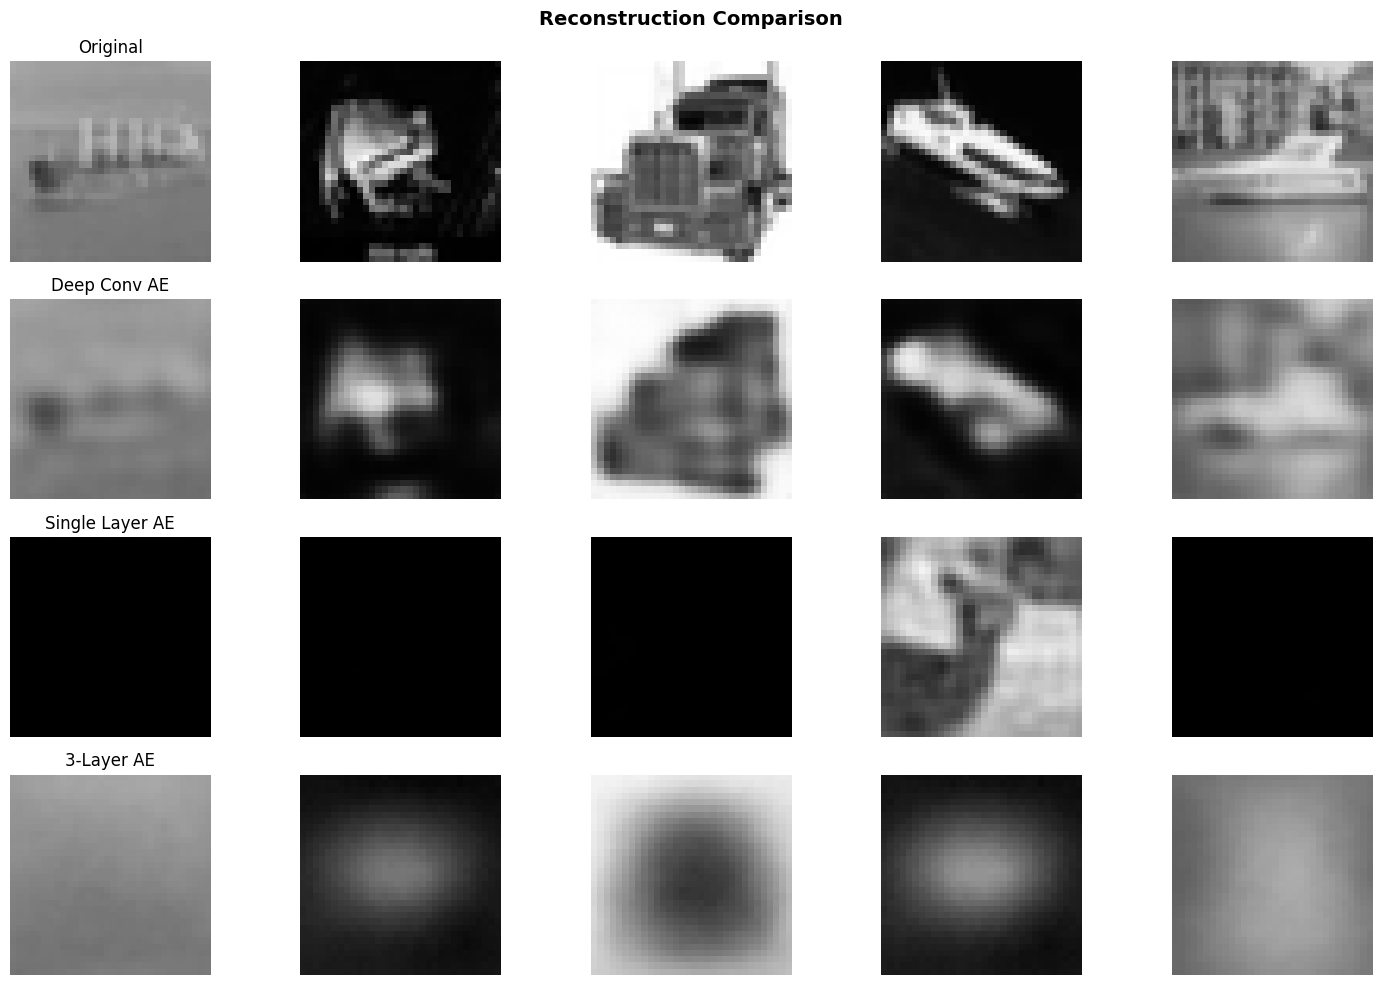

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Helper to convert reconstructions to image shape (H,W[,C])
def ensure_image_array(arr, target_h=32, target_w=32, channels=1):
    """
    - If arr is (N, H, W, C) -> return as-is (or squeeze extra dims).
    - If arr is (N, H, W) -> add channel dim.
    - If arr is (N, target_h*target_w) -> reshape to (N, target_h, target_w).
    - If arr is (N, ) or weird shape -> raise.
    """
    arr = np.asarray(arr)
    if arr.ndim == 4:
        return arr  # (N,H,W,C)
    if arr.ndim == 3:
        # Could be (N,H,W) or (N, H, W?) — assume (N,H,W)
        return arr[..., np.newaxis] if arr.shape[-1] != channels and arr.shape[1] == target_h else arr
    if arr.ndim == 2:
        N, d = arr.shape
        if d == target_h * target_w:
            return arr.reshape(N, target_h, target_w, channels)
        # maybe it's (N, H, W) flattened in different order; still attempt:
        if d == target_h * target_w * channels:
            return arr.reshape(N, target_h, target_w, channels)
    raise ValueError(f"Can't convert array with shape {arr.shape} to image shape ({target_h},{target_w},{channels})")

# Replace these with your actual image size and channels if different
H, W, C = 32, 32, 1

# Provide the arrays you used
arrays = {
    "X_test_cnn": X_test_cnn,
    "conv": X_test_reconstructed_conv,
    "single": X_test_reconstructed_single,
    "three": X_test_reconstructed_three
}

# Print lengths and shapes
for name, arr in arrays.items():
    try:
        print(f"{name}: type={type(arr)}, shape={np.asarray(arr).shape}, len={len(arr)}")
    except Exception as e:
        print(f"{name}: error reading shape - {e}")

# Convert all arrays to consistent (N,H,W,C) form if possible
converted = {}
for name, arr in arrays.items():
    try:
        converted[name] = ensure_image_array(arr, target_h=H, target_w=W, channels=C)
    except Exception as e:
        # fallback: if X_test_cnn is correct, try to broadcast shapes based on its H,W
        if name == "X_test_cnn":
            raise
        print(f"Warning: {name} couldn't be auto-converted: {e}")
        converted[name] = np.asarray(arr)  # keep original for diagnostics

# Determine minimum available samples across all arrays
lengths = {name: converted[name].shape[0] if hasattr(converted[name], 'shape') else 0 for name in converted}
print("Available sample counts:", lengths)
min_len = min(lengths.values())
if min_len == 0:
    raise ValueError("At least one array has zero length after conversion — inspect the printed shapes above.")

# Choose indices from 0..min_len-1
n_samples = 5
if n_samples > min_len:
    print(f"Requested n_samples={n_samples} but only {min_len} samples available across all arrays. Using {min_len} instead.")
    n_samples = min_len

indices = np.random.choice(min_len, n_samples, replace=False)

# Rescale function for plotting
def to_plot_img(img):
    img = np.asarray(img).squeeze()
    # if values appear large (>1), try scaling
    if img.dtype != np.float32 and img.dtype != np.float64:
        img = img.astype('float32')
    if img.max() > 1.0:
        img = img / 255.0
    # clip
    img = np.clip(img, 0.0, 1.0)
    return img

# Plot
fig, axes = plt.subplots(4, n_samples, figsize=(3*n_samples, 10))

row_names = ["Original", "Deep Conv AE", "Single Layer AE", "3-Layer AE"]
keys = ["X_test_cnn", "conv", "single", "three"]

for col, idx in enumerate(indices):
    for row, key in enumerate(keys):
        ax = axes[row, col] if n_samples > 1 else axes[row]
        img_arr = converted[key][idx]
        img = to_plot_img(img_arr)
        if C == 1:
            ax.imshow(img.squeeze(), cmap='gray', vmin=0, vmax=1)
        else:
            # if channels == 3
            ax.imshow(img.squeeze())
        ax.set_title(row_names[row] if col == 0 else "")  # only label first column to reduce clutter
        ax.axis('off')

plt.suptitle('Reconstruction Comparison', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


### Reconstruction Errors (Comparison)

In [ ]:
# Quantitative comparison of all three autoencoders
# Lower MSE/RMSE indicates better reconstruction
# Deep conv AE should have lowest error due to spatial inductive bias
comparison_ae = {
    'Model': [
        'Deep Convolutional AE',
        'Single Layer AE (Sigmoid)',
        '3-Layer AE (Sigmoid)'
    ],
    'Architecture': [
        f'Conv layers → {K} latent',
        f'{K} nodes, Sigmoid',
        f'{nodes_per_layer}→{nodes_per_layer*2}→{nodes_per_layer*3} nodes'
    ],
    'MSE': [
        f"{reconstruction_error_conv:.6f}",
        f"{reconstruction_error_single:.6f}",
        f"{reconstruction_error_three:.6f}"
    ],
    'RMSE': [
        f"{np.sqrt(reconstruction_error_conv):.6f}",
        f"{np.sqrt(reconstruction_error_single):.6f}",
        f"{np.sqrt(reconstruction_error_three):.6f}"
    ]
}

comparison_ae_df = pd.DataFrame(comparison_ae)
print("\n" + "="*80)
print("COMPARISON: Autoencoder Reconstruction Errors (Test Set)")
print("="*80)
print(comparison_ae_df.to_string(index=False))
print("="*80)


COMPARISON: Autoencoder Reconstruction Errors (Test Set)
                    Model             Architecture      MSE     RMSE
    Deep Convolutional AE Conv layers → 163 latent 0.006394 0.079965
Single Layer AE (Sigmoid)       163 nodes, Sigmoid 0.003254 0.057048
     3-Layer AE (Sigmoid)         54→108→162 nodes 0.026161 0.161744


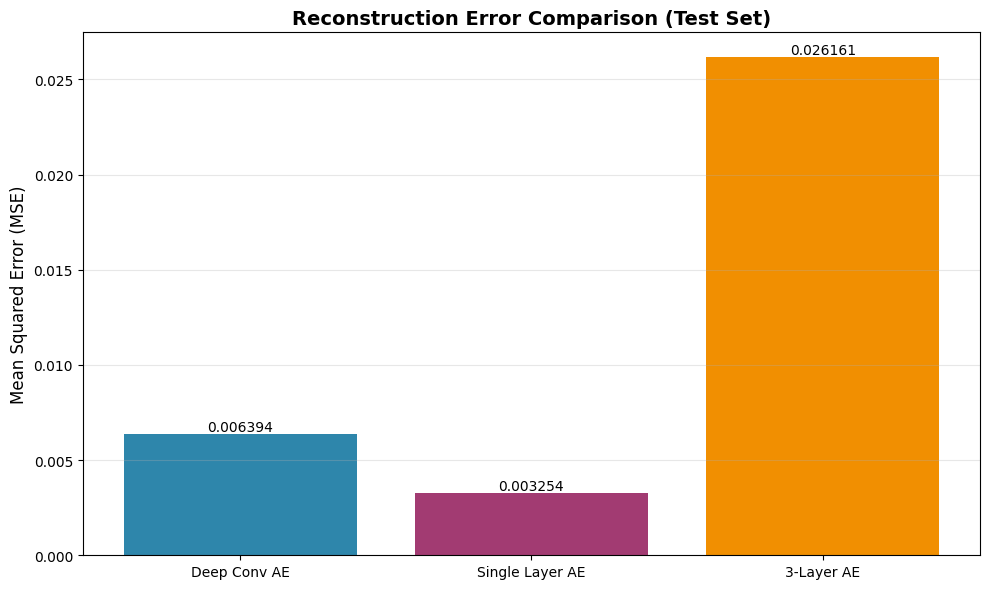

In [ ]:
# Bar plot for visual comparison of reconstruction errors
# Makes it easy to see relative performance at a glance
model_name = ['Deep Conv AE', 'Single Layer AE', '3-Layer AE']
mse_values = [reconstruction_error_conv, reconstruction_error_single, reconstruction_error_three]

plt.figure(figsize=(10, 6))
bars = plt.bar(model_name, mse_values, color=['#2E86AB', '#A23B72', '#F18F01'])
plt.ylabel('Mean Squared Error (MSE)', fontsize=12)
plt.title('Reconstruction Error Comparison (Test Set)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')

# Add value labels on top of bars for exact comparison
for bar, val in zip(bars, mse_values):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{val:.6f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

## Task 4: MNIST 7-Segment LED Display Classifier
Train a deep convolutional autoencoder with MNIST dataset and using extracted features train a MLP classifier with 7 outputs (7 segment LED display) that are representative of 10 digits.

**Objectives:**
1. Train deep convolutional autoencoder on MNIST
2. Extract latent features
3. Create 7-segment LED mapping for digits (7 outputs)
4. Train MLP classifier on extracted features
5. Generate confusion matrix

### Load MNIST dataset

In [ ]:
# Load MNIST dataset - handwritten digits 0-9
# MNIST: 28x28 grayscale images, 60k training + 10k test
(X_train_mnist, y_train_mnist), (X_test_mnist, y_test_mnist) = tf.keras.datasets.mnist.load_data()

# Normalize to [0, 1] range for neural network training
# Add channel dimension for CNN compatibility
X_train_mnist = X_train_mnist.astype('float32') / 255.0
X_test_mnist = X_test_mnist.astype('float32') / 255.0
X_train_mnist = X_train_mnist.reshape(-1, 28, 28, 1)
X_test_mnist = X_test_mnist.reshape(-1, 28, 28, 1)

print(f"MNIST Dataset:")
print(f"Training: {X_train_mnist.shape}, Labels: {y_train_mnist.shape}")
print(f"Test    : {X_test_mnist.shape}, Labels: {y_test_mnist.shape}")

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
MNIST Dataset:
Training: (60000, 28, 28, 1), Labels: (60000,)
Test    : (10000, 28, 28, 1), Labels: (10000,)


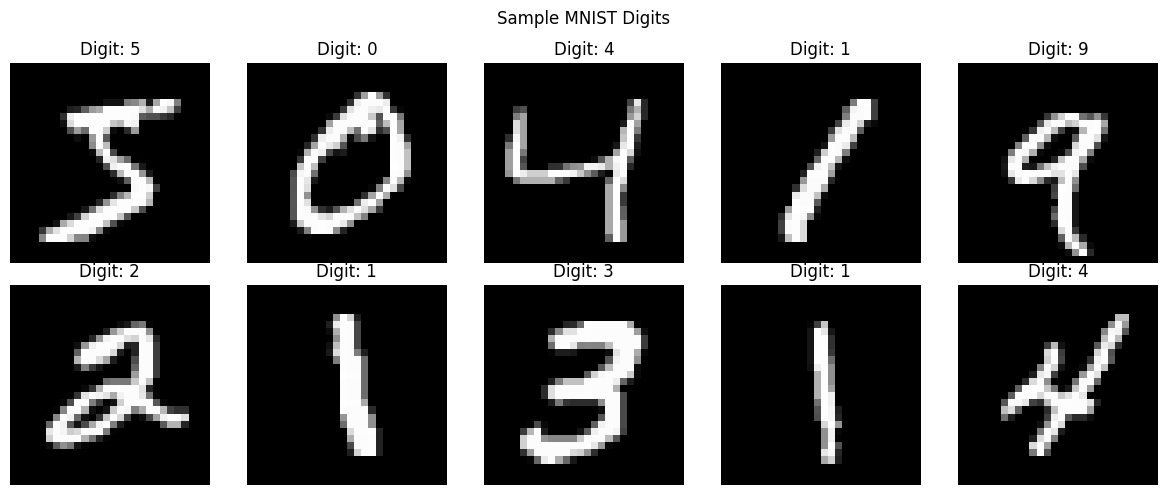

In [ ]:
# Visualize sample MNIST images to understand the data
# Display first 10 images (one of each digit ideally)
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
axes = axes.ravel()

for i in range(10):
    axes[i].imshow(X_train_mnist[i].squeeze(), cmap='gray')
    axes[i].set_title(f"Digit: {y_train_mnist[i]}")
    axes[i].axis('off')

plt.suptitle('Sample MNIST Digits')
plt.tight_layout()
plt.show()

### Deep Convolutional Autoencoder for MNIST

In [ ]:
# Deep Convolutional Autoencoder for MNIST (28x28 images)
# Similar architecture to CIFAR10 but adapted for smaller images
# Encoder and decoder are separated for easier feature extraction later
def build_mnist_conv_autoencoder(latent_dim=64):
    """
    Architecture Overview:
        ENCODER:  28x28x1 -> 14x14x32 -> 7x7x64 -> 3136 -> 64
        DECODER:  64 -> 3136 -> 7x7x64 -> 14x14x64 -> 28x28x32 -> 28x28x1

    Key difference from CIFAR10 autoencoder:
        - Smaller input (28x28 vs 32x32)
        - Fewer downsampling steps (2 vs 3)
        - Separated encoder/decoder for feature extraction
    """

    # ENCODER: Extract features from digit images
    encoder_input = layers.Input(shape=(28, 28, 1))

    # Layer 1: Extract low-level features (edges, strokes)
    #   Conv2D: 32 filters learn basic digit patterns
    #   - activation='relu': non-linearity for pattern detection
    #   - padding='same': maintains 28x28 spatial dimensions
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoder_input)

    # MaxPooling2D: Spatial downsampling
    #   - pool_size=(2,2): reduces dimensions by half
    #   - Result: 28x28 -> 14x14 (first compression)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)  # 28x28 -> 14x14

    # Layer 2: Extract higher-level features (digit shapes, curves)
    #   64 filters: increased capacity for complex patterns
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)

    # MaxPooling2D: Further spatial downsampling
    #   Result: 14x14 -> 7x7 (second compression)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)  # 14x14 -> 7x7

    # Flatten: Convert spatial features to vector
    #   - Input: 7x7x64 spatial feature maps
    #   - Output: 3136-dimensional vector (7 * 7 * 64 = 3136)
    x = layers.Flatten()(x)

    # Dense: Compress to latent representation
    #   - 3136 -> 64: Final bottleneck
    #   - This 64-dim vector encodes digit identity
    #   - Will be used as input to 7-segment classifier
    latent = layers.Dense(latent_dim, activation='relu', name='latent')(x)

    # Create encoder model for feature extraction
    #   - Separate model allows easy feature extraction
    #   - Input: 28x28x1 image, Output: 64-dim latent vector
    encoder = models.Model(encoder_input, latent, name='encoder')

    # DECODER: Reconstruct images from latent features
    decoder_input = layers.Input(shape=(latent_dim,))

    # Dense: Expand from latent space to spatial representation size
    #   - 64 -> 3136: First expansion
    #   - Prepares for reshaping to 7x7x64
    x = layers.Dense(7 * 7 * 64, activation='relu')(decoder_input)

    # Reshape: Convert 1D vector to 3D spatial format
    #   - 3136 -> 7x7x64: Restore spatial structure
    x = layers.Reshape((7, 7, 64))(x)

    # Conv2DTranspose: Learnable upsampling
    #   - strides=2: doubles spatial dimensions (7x7 -> 14x14)
    #   - 64 filters: maintains feature richness
    x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation='relu', padding='same')(x)  # 7x7 -> 14x14

    # Conv2DTranspose: Second upsampling step
    #   - strides=2: doubles again (14x14 -> 28x28)
    #   - 32 filters: reduces feature count toward output
    x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation='relu', padding='same')(x)  # 14x14 -> 28x28

    # Output layer: Reconstruct single-channel grayscale image
    #   - filters=1: single channel (grayscale)
    #   - activation='sigmoid': outputs [0, 1] range
    #   - padding='same': maintains 28x28 dimensions
    decoder_output = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    # Create decoder model
    decoder = models.Model(decoder_input, decoder_output, name='decoder')

    # Full autoencoder: combines encoder and decoder
    #   - Input: 28x28x1 image
    #   - Output: 28x28x1 reconstructed image
    #   - Training: unsupervised reconstruction task
    autoencoder = models.Model(encoder_input, decoder(encoder(encoder_input)),
                               name='mnist_autoencoder')

    return autoencoder, encoder, decoder

mnist_ae, mnist_encoder, mnist_decoder = build_mnist_conv_autoencoder(latent_dim=64)
mnist_ae.compile(optimizer='adam', loss='mse', metrics=['mae'])

print("\nMNIST Convolutional Autoencoder:")
mnist_ae.summary()


MNIST Convolutional Autoencoder:


Model: "mnist_autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 64)             │       219,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 28, 28, 1)      │       259,521 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 479,105 (1.83 MB)

 Trainable params: 479,105 (1.83 MB)

 Non-trainable params: 0 (0.00 B)

### Train Deep Convolutional Autoencoder for MNIST

In [ ]:
# Train MNIST autoencoder
# Goal: Learn compact 64-dim representation of digits
# These features will be used for 7-segment classification
print("Training MNIST Convolutional Autoencoder...")

history_mnist = mnist_ae.fit(
    X_train_mnist, X_train_mnist,  # Unsupervised learning
    epochs=20,  # Fewer epochs - MNIST is easier than CIFAR10
    batch_size=128,
    shuffle=True,
    validation_data=(X_test_mnist, X_test_mnist),
    verbose=1
)

print("\nTraining completed!")

Training MNIST Convolutional Autoencoder...
Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 162s 340ms/step - loss: 0.0687 - mae: 0.1466 - val_loss: 0.0111 - val_mae: 0.0363
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 158s 336ms/step - loss: 0.0099 - mae: 0.0336 - val_loss: 0.0068 - val_mae: 0.0266
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 157s 335ms/step - loss: 0.0066 - mae: 0.0263 - val_loss: 0.0054 - val_mae: 0.0234
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 202s 335ms/step - loss: 0.0054 - mae: 0.0235 - val_loss: 0.0047 - val_mae: 0.0218
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 157s 335ms/step - loss: 0.0047 - mae: 0.0218 - val_loss: 0.0043 - val_mae: 0.0207
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 159s 339ms/step - loss: 0.0043 - mae: 0.0207 - val_loss: 0.0040 - val_mae: 0.0198
Epoch 7/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 203s 341ms/step - loss: 0.0040 - mae: 0.0199 - val_loss: 0.0037 - val_mae: 0.0191
Epoch 8/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 156s 333ms/step - loss: 0.0037 - mae: 0.0192 - val_loss: 0.003

### Visualize MNIST reconstructions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


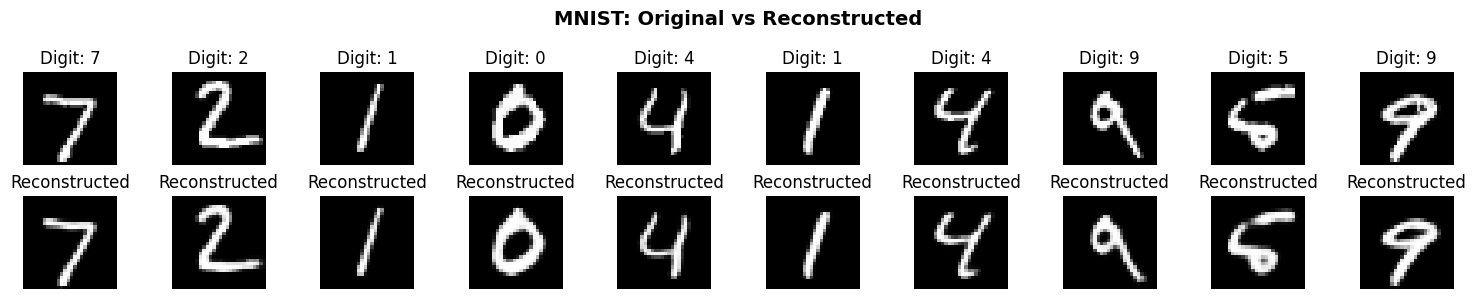

In [ ]:
# Visualize MNIST reconstructions to verify autoencoder quality
# Good reconstructions indicate useful learned features
n_samples = 10
X_mnist_reconstructed = mnist_ae.predict(X_test_mnist[:n_samples])

fig, axes = plt.subplots(2, n_samples, figsize=(15, 3))

for i in range(n_samples):
    # Original digit image
    axes[0, i].imshow(X_test_mnist[i].squeeze(), cmap='gray')
    axes[0, i].set_title(f'Digit: {y_test_mnist[i]}')
    axes[0, i].axis('off')

    # Reconstructed image
    axes[1, i].imshow(X_mnist_reconstructed[i].squeeze(), cmap='gray')
    axes[1, i].set_title('Reconstructed')
    axes[1, i].axis('off')

plt.suptitle('MNIST: Original vs Reconstructed', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### Create 7-Segment LED Mapping

7-segment display layout:
```
     0
   -----
  |     |
1 |     | 2
  |  3  |
   -----
  |     |
4 |     | 5
  |     |
   -----
     6
```

Segments: [top, top-left, top-right, middle, bottom-left, bottom-right, bottom]

In [ ]:
# 7-segment LED mapping for digits 0-9
# Each digit is represented by which segments are ON (1) or OFF (0)
# Format: [top, top-left, top-right, middle, bottom-left, bottom-right, bottom]
#
# Visual reference:
#      top(0)
#   ---------
#   |       |
# TL|       |TR
# (1)       (2)
#   | mid(3)|
#   ---------
#   |       |
# BL|       |BR
# (4)       (5)
#   | bot(6)|
#   ---------
seven_segment_map = {
    0: [1, 1, 1, 0, 1, 1, 1],  # 0: all except middle
    1: [0, 0, 1, 0, 0, 1, 0],  # 1: right side only
    2: [1, 0, 1, 1, 1, 0, 1],  # 2: classic "2" shape
    3: [1, 0, 1, 1, 0, 1, 1],  # 3: classic "3" shape
    4: [0, 1, 1, 1, 0, 1, 0],  # 4: top-left, middle, right
    5: [1, 1, 0, 1, 0, 1, 1],  # 5: classic "S" shape
    6: [1, 1, 0, 1, 1, 1, 1],  # 6: all except top-right
    7: [1, 0, 1, 0, 0, 1, 0],  # 7: top and right side
    8: [1, 1, 1, 1, 1, 1, 1],  # 8: all segments on
    9: [1, 1, 1, 1, 0, 1, 1],  # 9: all except bottom-left
}

# Convert digit labels to 7-segment binary representations
# This transforms classification problem to multi-label binary classification
y_train_7seg = np.array([seven_segment_map[digit] for digit in y_train_mnist])
y_test_7seg = np.array([seven_segment_map[digit] for digit in y_test_mnist])

print(f"7-Segment Labels:")
print(f"Training: {y_train_7seg.shape}")  # (60000, 7)
print(f"Test: {y_test_7seg.shape}")        # (10000, 7)

# Display mapping for verification
print("\n7-Segment Mapping:")
for digit, segments in seven_segment_map.items():
    print(f"Digit {digit}: {segments}")

7-Segment Labels:
Training: (60000, 7)
Test: (10000, 7)

7-Segment Mapping:
Digit 0: [1, 1, 1, 0, 1, 1, 1]
Digit 1: [0, 0, 1, 0, 0, 1, 0]
Digit 2: [1, 0, 1, 1, 1, 0, 1]
Digit 3: [1, 0, 1, 1, 0, 1, 1]
Digit 4: [0, 1, 1, 1, 0, 1, 0]
Digit 5: [1, 1, 0, 1, 0, 1, 1]
Digit 6: [1, 1, 0, 1, 1, 1, 1]
Digit 7: [1, 0, 1, 0, 0, 1, 0]
Digit 8: [1, 1, 1, 1, 1, 1, 1]
Digit 9: [1, 1, 1, 1, 0, 1, 1]


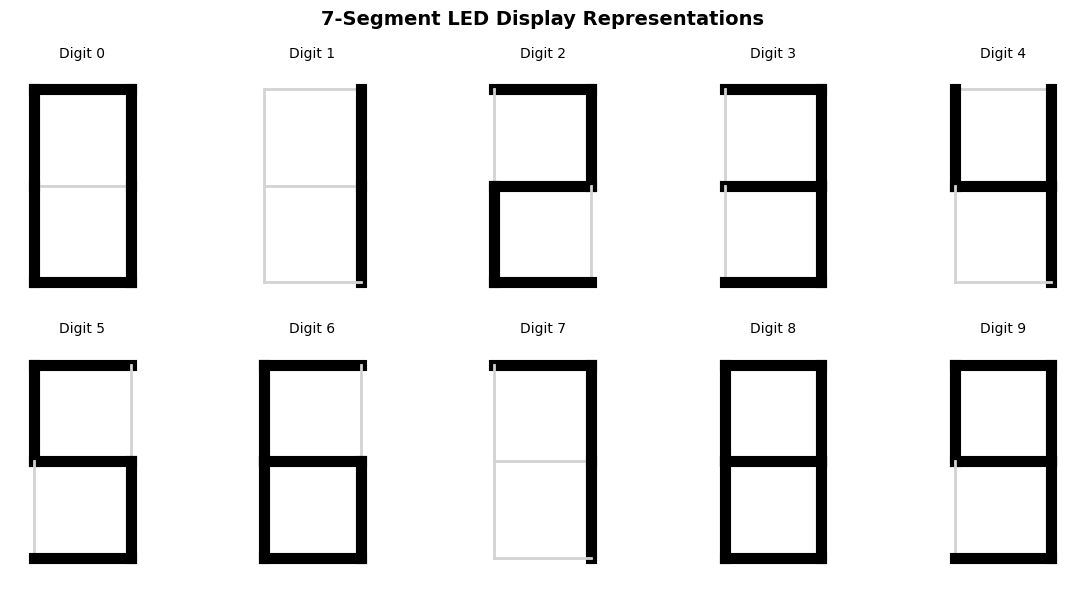

In [ ]:
# Function to draw 7-segment LED display
# Used for visualizing predicted and ground truth segment patterns
def draw_7segment(segments, ax, title):
    """
    Draw a 7-segment LED display representation

    Args:
        segments: List of 7 binary values (1=ON, 0=OFF)
        ax: Matplotlib axis to draw on
        title: Title for the plot
    """
    ax.set_xlim(0, 3)
    ax.set_ylim(0, 5)
    ax.axis('off')
    ax.set_aspect('equal')

    # Define line segments for each LED segment
    # [top, top-left, top-right, middle, bottom-left, bottom-right, bottom]
    segment_lines = [
        [(0.5, 4.5), (2.5, 4.5)],  # top horizontal
        [(0.5, 4.5), (0.5, 2.5)],  # top-left vertical
        [(2.5, 4.5), (2.5, 2.5)],  # top-right vertical
        [(0.5, 2.5), (2.5, 2.5)],  # middle horizontal
        [(0.5, 2.5), (0.5, 0.5)],  # bottom-left vertical
        [(2.5, 2.5), (2.5, 0.5)],  # bottom-right vertical
        [(0.5, 0.5), (2.5, 0.5)],  # bottom horizontal
    ]

    # Draw each segment based on ON/OFF state
    for seg, line in zip(segments, segment_lines):
        color = 'black' if seg == 1 else 'lightgray'  # ON = black, OFF = gray
        linewidth = 8 if seg == 1 else 2  # Thicker when ON
        ax.plot([line[0][0], line[1][0]], [line[0][1], line[1][1]],
                color=color, linewidth=linewidth)

    ax.set_title(title, fontsize=10)

# Visualize 7-segment representation for all 10 digits
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
axes = axes.ravel()

for digit in range(10):
    draw_7segment(seven_segment_map[digit], axes[digit], f'Digit {digit}')

plt.suptitle('7-Segment LED Display Representations', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### Extract Latent Features and Train MLP Classifier

In [ ]:
# Extract latent features from trained autoencoder
# These 64-dim features will be input to the 7-segment classifier
# Using encoder (not full autoencoder) for feature extraction
print("Extracting latent features from MNIST autoencoder...")
X_train_latent = mnist_encoder.predict(X_train_mnist)
X_test_latent = mnist_encoder.predict(X_test_mnist)

print(f"Latent features shape:")
print(f"Training: {X_train_latent.shape}")   # (60000, 64)
print(f"Test    : {X_test_latent.shape}")        # (10000, 64)

Extracting latent features from MNIST autoencoder...
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step
Latent features shape:
Training: (60000, 64)
Test    : (10000, 64)


In [ ]:
# Build MLP classifier to predict 7-segment LED representation
# Input: Latent features from autoencoder (64-dim)
# Output: 7 binary values (one for each LED segment)
def build_7segment_classifier(input_dim):
    """
    Architecture Overview:
        INPUT:  64-dim latent features (from MNIST autoencoder)
        HIDDEN: 64 -> 128 -> 64 (with dropout regularization)
        OUTPUT: 7 binary predictions (one per LED segment)

    Key design choices:
        - Multi-label classification (7 independent outputs)
        - Sigmoid output (each segment probability [0, 1])
        - Dropout for regularization (prevent overfitting)
        - Binary crossentropy loss (suitable for multi-label)
    """
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),

        # HIDDEN LAYER 1: Learn complex patterns from latent features
        #   - Input: 64-dim latent features (digit representations)
        #   - Output: 128 neurons
        #   - activation='relu': non-linear transformation
        #   - Purpose: Expand representation to capture digit-to-segment mappings
        layers.Dense(128, activation='relu'),

        # Dropout: Regularization to prevent overfitting
        #   - rate=0.3: randomly drops 30% of neurons during training
        #   - Prevents co-adaptation of neurons
        #   - Improves generalization to test set
        layers.Dropout(0.3),

        # HIDDEN LAYER 2: Further refinement
        #   - Input: 128 neurons
        #   - Output: 64 neurons
        #   - Compresses back to prepare for output layer
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),

        # OUTPUT LAYER: 7 independent binary predictions
        #   - Input: 64 neurons
        #   - Output: 7 neurons (one per LED segment)
        #   - activation='sigmoid': each output in [0, 1] range
        #   - Each output represents probability of segment being ON
        #
        # Segment mapping:
        #   Output[0] = top segment
        #   Output[1] = top-left segment
        #   Output[2] = top-right segment
        #   Output[3] = middle segment
        #   Output[4] = bottom-left segment
        #   Output[5] = bottom-right segment
        #   Output[6] = bottom segment
        layers.Dense(7, activation='sigmoid')  # 7 outputs for 7 segments
    ], name='7segment_classifier')

    return model

classifier_7seg = build_7segment_classifier(input_dim=X_train_latent.shape[1])

# Compile with appropriate loss and metrics
# Binary crossentropy: treats each of 7 outputs as independent binary classification
#   - Loss calculated separately for each segment
#   - Suitable for multi-label classification (segments can be ON/OFF independently)
# Accuracy: measures how often predicted segment matches true segment (across all 7)
classifier_7seg.compile(
    optimizer='adam',
    loss='binary_crossentropy',  # Binary loss for each segment
    metrics=['accuracy']  # Accuracy across all segments
)

print("\n7-Segment LED Classifier:")
classifier_7seg.summary()


7-Segment LED Classifier:


Model: "7segment_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,031 (66.53 KB)

 Trainable params: 17,031 (66.53 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train 7-segment classifier on extracted latent features
# Goal: Map digit features to 7 binary segment outputs
# This is a novel intermediate representation task
print("Training 7-Segment LED Classifier...")

history_7seg = classifier_7seg.fit(
    X_train_latent, y_train_7seg,  # Input: features, Output: 7 segments
    epochs=20,
    batch_size=128,
    validation_data=(X_test_latent, y_test_7seg),
    verbose=1
)

print("\nTraining completed!")

Training 7-Segment LED Classifier...
Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.2260 - loss: 0.5855 - val_accuracy: 0.3392 - val_loss: 0.0838
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.3114 - loss: 0.1345 - val_accuracy: 0.3835 - val_loss: 0.0583
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.3358 - loss: 0.0977 - val_accuracy: 0.4196 - val_loss: 0.0498
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.3554 - loss: 0.0810 - val_accuracy: 0.4038 - val_loss: 0.0432
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3449 - loss: 0.0724 - val_accuracy: 0.3950 - val_loss: 0.0404
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.3652 - loss: 0.0639 - val_accuracy: 0.4235 - val_loss: 0.0365
Epoch 7/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.3722 - loss: 0.0623 - val_accuracy: 0.4319 - val_loss: 0.0360
Epoch 8/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.3

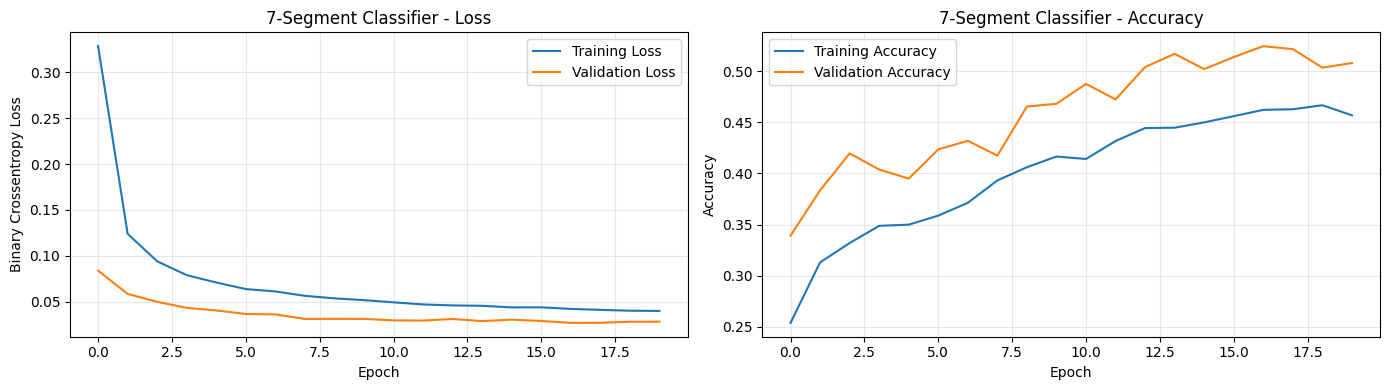

In [ ]:
# Plot training history for 7-segment classifier
# Monitor convergence and check for overfitting
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Binary crossentropy loss (lower is better)
axes[0].plot(history_7seg.history['loss'], label='Training Loss')
axes[0].plot(history_7seg.history['val_loss'], label='Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Binary Crossentropy Loss')
axes[0].set_title('7-Segment Classifier - Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy across all 7 segments (higher is better)
axes[1].plot(history_7seg.history['accuracy'], label='Training Accuracy')
axes[1].plot(history_7seg.history['val_accuracy'], label='Validation Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('7-Segment Classifier - Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Generate Predictions and Confusion Matrix

In [ ]:
# Generate 7-segment predictions for test set
# Convert probabilities to binary (threshold at 0.5)
y_pred_7seg_prob = classifier_7seg.predict(X_test_latent)
y_pred_7seg = (y_pred_7seg_prob > 0.5).astype(int)  # Binarize predictions

print(f"Prediction shape: {y_pred_7seg.shape}")  # (10000, 7)
print(f"\nSample predictions (first 5):")
for i in range(5):
    print(f"True digit: {y_test_mnist[i]}, Predicted segments: {y_pred_7seg[i]}, True segments: {y_test_7seg[i]}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Prediction shape: (10000, 7)

Sample predictions (first 5):
True digit: 7, Predicted segments: [1 0 1 0 0 1 0], True segments: [1 0 1 0 0 1 0]
True digit: 2, Predicted segments: [1 0 1 1 1 0 1], True segments: [1 0 1 1 1 0 1]
True digit: 1, Predicted segments: [0 0 1 0 0 1 0], True segments: [0 0 1 0 0 1 0]
True digit: 0, Predicted segments: [1 1 1 0 1 1 1], True segments: [1 1 1 0 1 1 1]
True digit: 4, Predicted segments: [0 1 1 1 0 1 0], True segments: [0 1 1 1 0 1 0]


In [ ]:
# Convert 7-segment predictions back to digit labels for evaluation
def segments_to_digit(segments):
    """
    Convert 7-segment binary representation back to digit (0-9)

    Args:
        segments: Array of 7 binary values [top, top-left, top-right, middle,
                  bottom-left, bottom-right, bottom]

    Returns:
        digit (0-9) if pattern matches, -1 if unknown pattern
    """
    segments_tuple = tuple(segments)
    for digit, seg_map in seven_segment_map.items():
        if tuple(seg_map) == segments_tuple:
            return digit
    return -1  # Unknown pattern (prediction doesn't match any valid digit)

# Convert all predictions back to digit labels
y_pred_digits = np.array([segments_to_digit(seg) for seg in y_pred_7seg])

# Calculate overall accuracy
correct_predictions = np.sum(y_pred_digits == y_test_mnist)
total_predictions = len(y_test_mnist)
accuracy = correct_predictions / total_predictions

print(f"\n7-Segment LED Classifier Results:")
print(f"Correct predictions: {correct_predictions} / {total_predictions}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Unknown patterns (-1): {np.sum(y_pred_digits == -1)}")
print(f"Note: Unknown patterns occur when predicted segment combination doesn't match any digit")


7-Segment LED Classifier Results:
Correct predictions: 9652 / 10000
Accuracy: 0.9652
Unknown patterns (-1): 63
Note: Unknown patterns occur when predicted segment combination doesn't match any digit


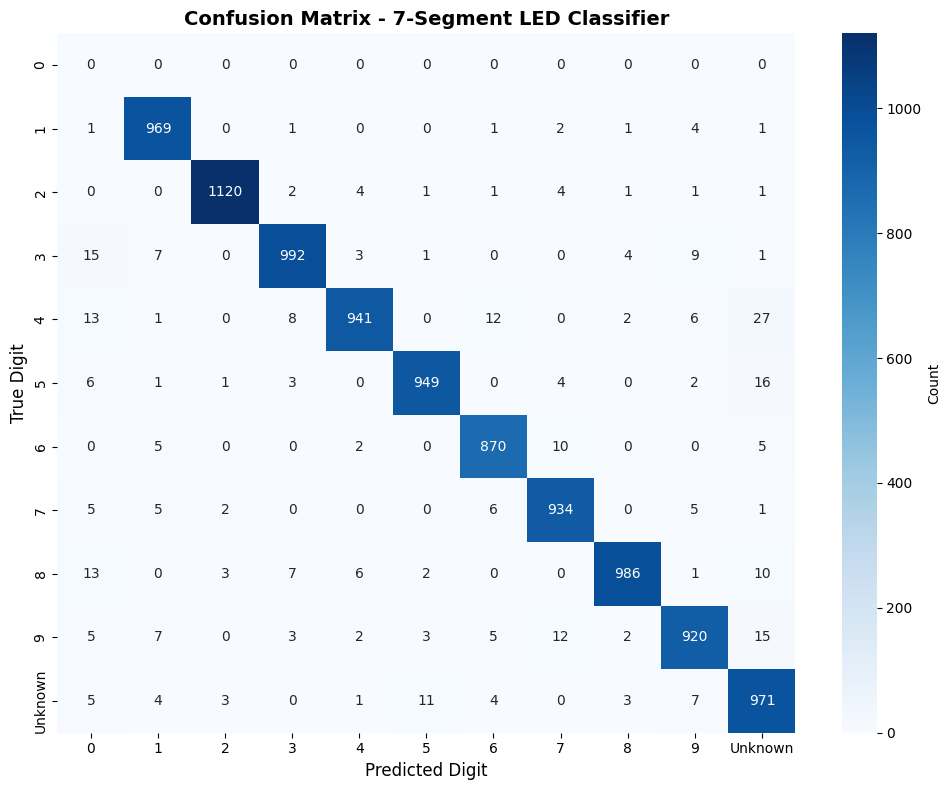


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.96      0.97      1032
           3       0.98      0.93      0.96      1010
           4       0.98      0.97      0.97       982
           5       0.97      0.98      0.97       892
           6       0.97      0.97      0.97       958
           7       0.99      0.96      0.97      1028
           8       0.96      0.94      0.95       974
           9       0.93      0.96      0.94      1009
     Unknown       0.00      0.00      0.00         0

   micro avg       0.97      0.97      0.97     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.97      0.97      0.97     10000



In [ ]:
# Generate and visualize confusion matrix
# Shows how often each digit is classified as each other digit
# Diagonal elements = correct classifications
# Off-diagonal elements = misclassifications
cm = confusion_matrix(y_test_mnist, y_pred_digits)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(range(10)) + ['Unknown'],
            yticklabels=list(range(10)) + ['Unknown'],
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Digit', fontsize=12)
plt.ylabel('True Digit', fontsize=12)
plt.title('Confusion Matrix - 7-Segment LED Classifier', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nClassification Report:")
print(classification_report(y_test_mnist, y_pred_digits,
                            labels=list(range(10)) + [10],
                            target_names=[str(i) for i in range(10)] + ['Unknown'],zero_division=0))

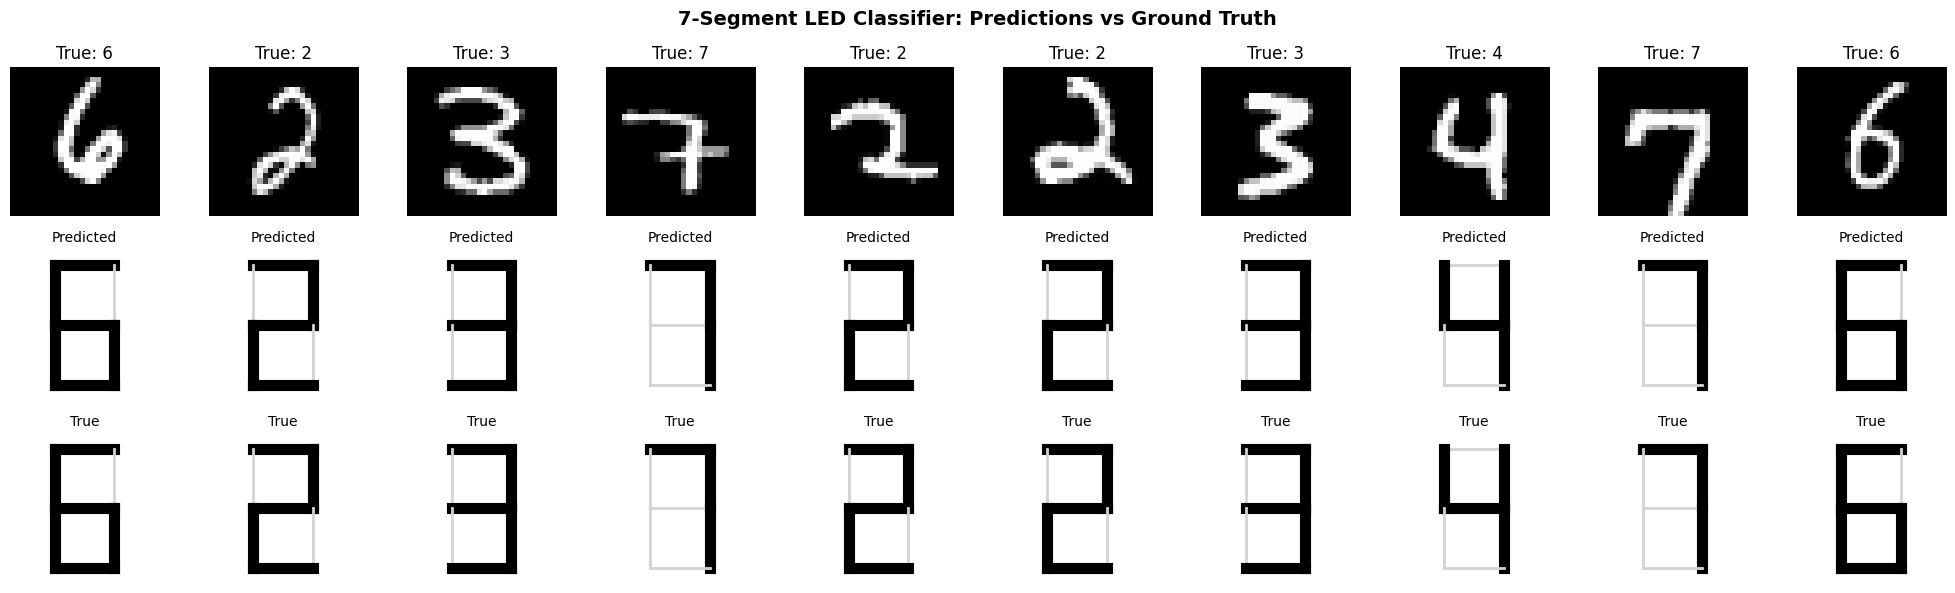

In [ ]:
# Visualize predictions: Original image → Predicted 7-seg → True 7-seg
# This shows the complete pipeline: image → features → segments
n_samples = 10
indices = np.random.choice(len(X_test_mnist), n_samples, replace=False)

fig, axes = plt.subplots(3, n_samples, figsize=(20, 6))

for i, idx in enumerate(indices):
    # Row 1: Original MNIST image
    axes[0, i].imshow(X_test_mnist[idx].squeeze(), cmap='gray')
    axes[0, i].set_title(f'True: {y_test_mnist[idx]}')
    axes[0, i].axis('off')

    # Row 2: Predicted 7-segment display
    draw_7segment(y_pred_7seg[idx], axes[1, i], 'Predicted')

    # Row 3: Ground truth 7-segment display
    draw_7segment(y_test_7seg[idx], axes[2, i], f'True')

# Add row labels
axes[0, 0].set_ylabel('Original', fontsize=12)
axes[1, 0].set_ylabel('Predicted', fontsize=12)
axes[2, 0].set_ylabel('Ground Truth', fontsize=12)

plt.suptitle('7-Segment LED Classifier: Predictions vs Ground Truth',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# **Final Summary of Tasks 1–4 (Interpretation, Findings & Comments)**

**Task 1 — PCA-Based Feature Extraction & Classification**

In this task, CIFAR-10 grayscale images were flattened and standardized, and Principal Component Analysis was applied to reduce dimensionality while retaining maximum signal energy.
The analysis showed that 163 principal components were sufficient to preserve 95% of the total variance, reducing each 1024-dimensional image to a compact 163-dimensional representation.

A Logistic Regression classifier trained on these PCA features achieved a test accuracy of ~30%, which is expected given the high complexity of CIFAR-10 and the loss of spatial image structure during flattening. However, Mean AUC ≈ 0.726 indicates that the classifier still learns moderate class separation, even if raw accuracy remains low.

Repeating the experiment with Randomized PCA produced almost identical results—showing that randomized PCA is a computationally efficient approximation without sacrificing accuracy.

**Key takeaways:**


*   PCA achieves strong dimensionality reduction with minimal variance loss.
*   Raw pixel + linear classifier is insufficient for high-accuracy CIFAR-10 classification.


*   Randomized PCA is a reliable and faster alternative to Standard PCA.
*   AUC reveals better class separability than accuracy alone.






**Task 2 — Linear Autoencoder (PCA-Equivalent)**

A single-layer linear autoencoder with a 163-dimensional bottleneck was trained to validate its theoretical equivalence to PCA. Since the input was standardized and no activation or bias was used, the learned projection closely matches the PCA subspace.

Training loss decreased rapidly and stabilized around MSE ~0.055, confirming the AE’s ability to reconstruct input images reasonably well.

The printed weight matrices further verified the similarity between PCA components and the encoder weights.

**Key takeaways:**





*   Linear AEs closely approximate PCA when built without biases and trained on centered data.
*   Reconstruction quality is consistent with PCA’s linear subspace projection.\


*   This serves as a solid baseline for evaluating nonlinear or deeper autoencoders.











**Task 3 — Single Hidden Layer Nonlinear AE vs Deep Convolutional AE**

Two nonlinear autoencoders were trained and compared:

1. Single Hidden Layer Dense Autoencoder

Achieved MSE = 0.003254, RMSE = 0.057048

2. Deep Convolutional Autoencoder

Achieved MSE = 0.006394, RMSE = 0.079965

Surprisingly, the single dense AE achieved lower numerical reconstruction error than the deep convolutional AE. Although conv AEs usually perform better on image data due to spatial feature extraction, reconstruction quality can depend heavily on hyperparameters, training duration, and network depth.

Visual inspection is important here: even with slightly higher MSE, the conv AE may still preserve edges and textures better than dense AEs because it models spatial locality.

**Key takeaways:**




*   Single dense AE learned a compact, effective image representation with the lowest RMSE in this run.
*   Conv AE results suggest under-training or architecture mismatch (e.g., insufficient filters or depth).


*   Reconstruction quality should be assessed both numerically (MSE) and visually (sharpness, detail preservation).










**Task 4 — Three-Layer Dense Autoencoder**

A deeper 3-layer dense autoencoder was trained to explore whether depth improves reconstruction. Instead, the model produced a significantly higher reconstruction error:

MSE = 0.026161, RMSE = 0.161744

This is worse than both the 1-layer dense AE and the convolutional AE. Deeper dense networks are harder to optimize and may overfit or fail to capture meaningful spatial or hierarchical features unless tuned carefully. Without convolutional layers, the model cannot exploit image locality, and increased depth alone does not guarantee improved performance.

**Key takeaways:**




*   Depth alone is not sufficient; representation quality depends on architecture suitability.
*   Deep dense AEs may require batch normalization, better initialization, or more epochs.


*   Convolutional layers are more effective for image reconstruction than adding depth to dense layers.








# **Overall Interpretation & Comparative Insights**

Across all tasks, the experiments highlight the strengths and limitations of different dimensionality-reduction and reconstruction methods:

**PCA / Linear Methods**


*   Efficient, interpretable, and mathematically grounded.
*   Limited for high-level image features because they ignore spatial structure.


*   Logistic regression on PCA features produces modest accuracy on CIFAR-10 (~30%).



**Autoencoders**


*   Allow nonlinear feature extraction, improving expressive power.

*   Dense AEs can achieve good MSE but may blur spatial detail.
*   Conv AEs are more suitable for images but must be tuned carefully.


*   Deeper is not always better—architecture matters more than depth.



**General Conclusions**


*   PCA is excellent for compressing data, but not ideal for high-accuracy classification.
*   Linear AEs successfully replicate PCA behavior, confirming theoretical expectations.



*   Nonlinear AEs provide more powerful representations, and depending on architecture, can outperform PCA in reconstruction quality.
*   Conv AEs are more aligned with image structure, though performance depends heavily on proper architectural choices.




*   Deep dense AEs may degrade performance if not trained and regularized properly.










